In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm  
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import numpy as np

# ============================================
# 1. Dataset
# ============================================
class PICDDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = Path(img_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row['folder_name'] / row['img_id']
        
        if not img_path.exists():
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        label = int(row['category_id']) - 1  # 0-indexed (1-24 → 0-23)
        
        return image, label

# ============================================
# 2. Model
# ============================================
class DINOClassifier(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        # Load frozen DINO
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        self.dino.eval()
        for param in self.dino.parameters():
            param.requires_grad = False
        
        # Linear classifier
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.dino(x)
        logits = self.classifier(features)
        return logits

# ============================================
# 3. Setup
# ============================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🔧 Using device: {device}')
print(f'   GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A"}')

# Paths
LOCAL_DIR = '/scratch.global/kanth042/CV_project'
csv_path = f'{LOCAL_DIR}/labels_PICD.csv'
img_dir = f'{LOCAL_DIR}/PICD'

# ============================================
# 4. Data Preparation
# ============================================
print('\n' + '='*70)
print('📊 DATA PREPARATION')
print('='*70)

# Load data
df = pd.read_csv(csv_path)
print(f'Total images in CSV: {len(df):,}')

# Filter for single-label only
df['category_id'] = df['category_id'].astype(str)
df_single = df[~df['category_id'].str.contains(',')].copy()
df_single['category_id'] = df_single['category_id'].astype(int)
print(f'Single-label images: {len(df_single):,}')

# Verify images exist on disk
print('\n🔍 Verifying images exist on disk...')
img_dir_path = Path(img_dir)
existing_mask = []

for idx, row in tqdm(df_single.iterrows(), total=len(df_single), desc='Checking files'):
    img_path = img_dir_path / row['folder_name'] / row['img_id']
    existing_mask.append(img_path.exists())

df_existing = df_single[existing_mask].copy()

print(f'✓ Images on disk: {len(df_existing):,}')
print(f'✗ Missing images: {len(df_single) - len(df_existing):,}')
print(f'\n📈 Categories: {sorted(df_existing["category_id"].unique())}')

# Category distribution
print('\n📊 Category Distribution:')
cat_counts = df_existing['category_id'].value_counts().sort_index()
for cat_id, count in cat_counts.items():
    print(f'   Category {cat_id:2d}: {count:4d} images')

# ============================================
# 5. Train/Val Split
# ============================================
print('\n' + '='*70)
print('✂️  TRAIN/VAL SPLIT')
print('='*70)

train_df, val_df = train_test_split(
    df_existing, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_existing['category_id']
)

train_df.to_csv(f'{LOCAL_DIR}/train_split.csv', index=False)
val_df.to_csv(f'{LOCAL_DIR}/val_split.csv', index=False)

print(f'Train set: {len(train_df):,} images ({len(train_df)/len(df_existing)*100:.1f}%)')
print(f'Val set:   {len(val_df):,} images ({len(val_df)/len(df_existing)*100:.1f}%)')

# ============================================
# 6. Transforms - MINIMAL FOR COMPOSITION
# ============================================
print('\n' + '='*70)
print('🖼️  TRANSFORMS (Composition-Preserving)')
print('='*70)

# SAME transform for train and val - no augmentation!
# Composition is absolute, any spatial change = wrong label
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # DINO requires 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

print('✓ Train transform: Resize(224) → ToTensor → Normalize')
print('✓ Val transform:   Resize(224) → ToTensor → Normalize')
print('  (No augmentation - composition is absolute!)')

# ============================================
# 7. Datasets and DataLoaders
# ============================================
print('\n' + '='*70)
print('🔄 DATALOADERS')
print('='*70)

train_dataset = PICDDataset(f'{LOCAL_DIR}/train_split.csv', img_dir, transform)
val_dataset = PICDDataset(f'{LOCAL_DIR}/val_split.csv', img_dir, transform)

batch_size = 256
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=8, 
    pin_memory=True, 
    prefetch_factor=2
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=8, 
    pin_memory=True, 
    prefetch_factor=2
)

print(f'Batch size: {batch_size}')
print(f'Train batches: {len(train_loader):,}')
print(f'Val batches:   {len(val_loader):,}')

# ============================================
# 8. Model Setup
# ============================================
print('\n' + '='*70)
print('🤖 MODEL SETUP')
print('='*70)

print('Loading DINO backbone...')
model = DINOClassifier(num_classes=24).to(device)

# Count parameters
trainable_params = sum(p.numel() for p in model.classifier.parameters())
frozen_params = sum(p.numel() for p in model.dino.parameters())

print(f'✓ DINO loaded (dinov2_vitb14)')
print(f'  Frozen parameters:    {frozen_params:,}')
print(f'  Trainable parameters: {trainable_params:,} (linear classifier only)')
print(f'  Total parameters:     {frozen_params + trainable_params:,}')

# ============================================
# 9. Training Setup
# ============================================
print('\n' + '='*70)
print('⚙️  TRAINING SETUP')
print('='*70)

# Optimizer
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler
max_epochs = 10
scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-6)

# Loss
criterion = nn.CrossEntropyLoss()

# Early stopping
best_val_acc = 0.0
patience = 5
patience_counter = 0

print(f'Optimizer:      Adam (lr=1e-3, weight_decay=1e-4)')
print(f'Scheduler:      CosineAnnealingLR (T_max={max_epochs}, eta_min=1e-6)')
print(f'Loss:           CrossEntropyLoss')
print(f'Max epochs:     {max_epochs}')
print(f'Early stopping: patience={patience}')

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'lr': []
}

# ============================================
# 10. Training Loop
# ============================================
print('\n' + '='*70)
print('🚀 TRAINING START')
print('='*70 + '\n')

for epoch in range(max_epochs):
    
    # ========================================
    # TRAINING PHASE
    # ========================================
    model.train()
    model.dino.eval()  # Keep DINO frozen
    
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(
        train_loader, 
        desc=f'Epoch {epoch+1}/{max_epochs} [Train]',
        leave=False
    )
    
    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Metrics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()
        train_total += labels.size(0)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_acc = 100. * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)
    
    # ========================================
    # VALIDATION PHASE
    # ========================================
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        pbar = tqdm(
            val_loader, 
            desc=f'Epoch {epoch+1}/{max_epochs} [Val]',
            leave=False
        )
        
        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*val_correct/val_total:.2f}%'
            })
    
    val_acc = 100. * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    current_lr = optimizer.param_groups[0]['lr']
    
    # ========================================
    # SAVE HISTORY
    # ========================================
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # ========================================
    # PRINT EPOCH SUMMARY
    # ========================================
    print(f'\n{"="*70}')
    print(f'Epoch {epoch+1}/{max_epochs} Summary:')
    print(f'{"="*70}')
    print(f'  Train Loss: {avg_train_loss:.4f}  |  Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss:   {avg_val_loss:.4f}  |  Val Acc:   {val_acc:.2f}%')
    print(f'  Learning Rate: {current_lr:.6f}')
    
    # ========================================
    # SAVE BEST MODEL & EARLY STOPPING
    # ========================================
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'history': history
        }, f'{LOCAL_DIR}/best_dino_classifier.pth')
        
        print(f'  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)')
    else:
        patience_counter += 1
        print(f'  Patience: {patience_counter}/{patience}')
        
        if patience_counter >= patience:
            print(f'\n⚠️  Early stopping triggered at epoch {epoch+1}')
            break
    
    # Step scheduler
    scheduler.step()
    print()

# ============================================
# 11. Training Complete
# ============================================
print('\n' + '='*70)
print('🎉 TRAINING COMPLETE')
print('='*70)
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
print('='*70)

# Save final training history
with open(f'{LOCAL_DIR}/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f'\n✓ Training history saved to: {LOCAL_DIR}/training_history.json')
print(f'✓ Best model saved to: {LOCAL_DIR}/best_dino_classifier.pth')

# ============================================
# 12. Plot Training Curves
# ============================================
print('\n' + '='*70)
print('📊 PLOTTING TRAINING CURVES')
print('='*70)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best Val: {best_val_acc:.2f}%', alpha=0.7)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{LOCAL_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
print(f'✓ Training curves saved to: {LOCAL_DIR}/training_curves.png')
plt.show()

# ============================================
# 13. Final Statistics
# ============================================
print('\n' + '='*70)
print('📈 FINAL STATISTICS')
print('='*70)

print(f'Total Epochs Run: {len(history["train_acc"])}')
print(f'Best Epoch:       {np.argmax(history["val_acc"]) + 1}')
print(f'Final Train Acc:  {history["train_acc"][-1]:.2f}%')
print(f'Final Val Acc:    {history["val_acc"][-1]:.2f}%')
print(f'Best Val Acc:     {best_val_acc:.2f}%')
print(f'Train/Val Gap:    {history["train_acc"][-1] - history["val_acc"][-1]:.2f}%')

if history["train_acc"][-1] - history["val_acc"][-1] > 10:
    print('  ⚠️  Large train/val gap - possible overfitting')
else:
    print('  ✓ Reasonable train/val gap')

print('='*70)
print('\n✅ All done! Model ready for inference.')

Loading trained model...


Using cache found in /users/7/kanth042/.cache/torch/hub/facebookresearch_dinov2_main


Loaded model from epoch 5 with Val Acc: 69.38%

Validation set: 8589 images

Generating predictions...


Predicting: 100%|██████████| 34/34 [00:34<00:00,  1.02s/it]



Overall Validation Accuracy: 68.89%

Plotting training curves...
Saved: /scratch.global/kanth042/CV_project/training_curves.png


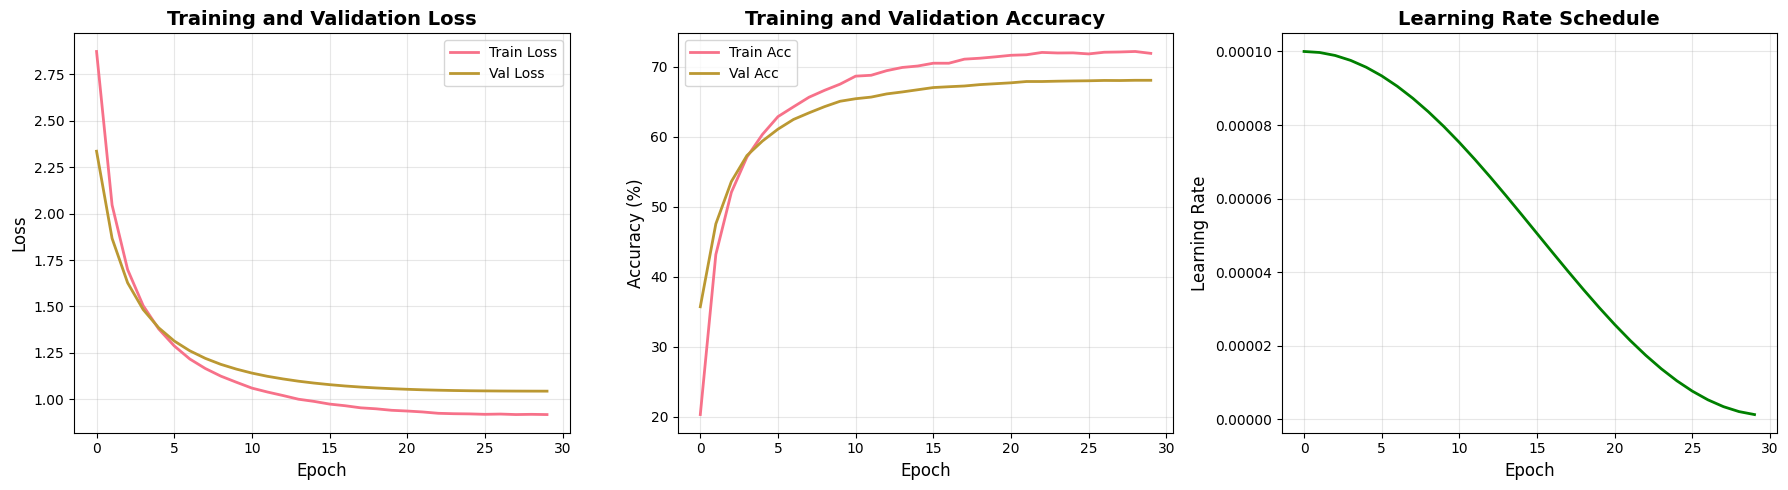


Generating confusion matrix...
Saved: /scratch.global/kanth042/CV_project/confusion_matrix.png


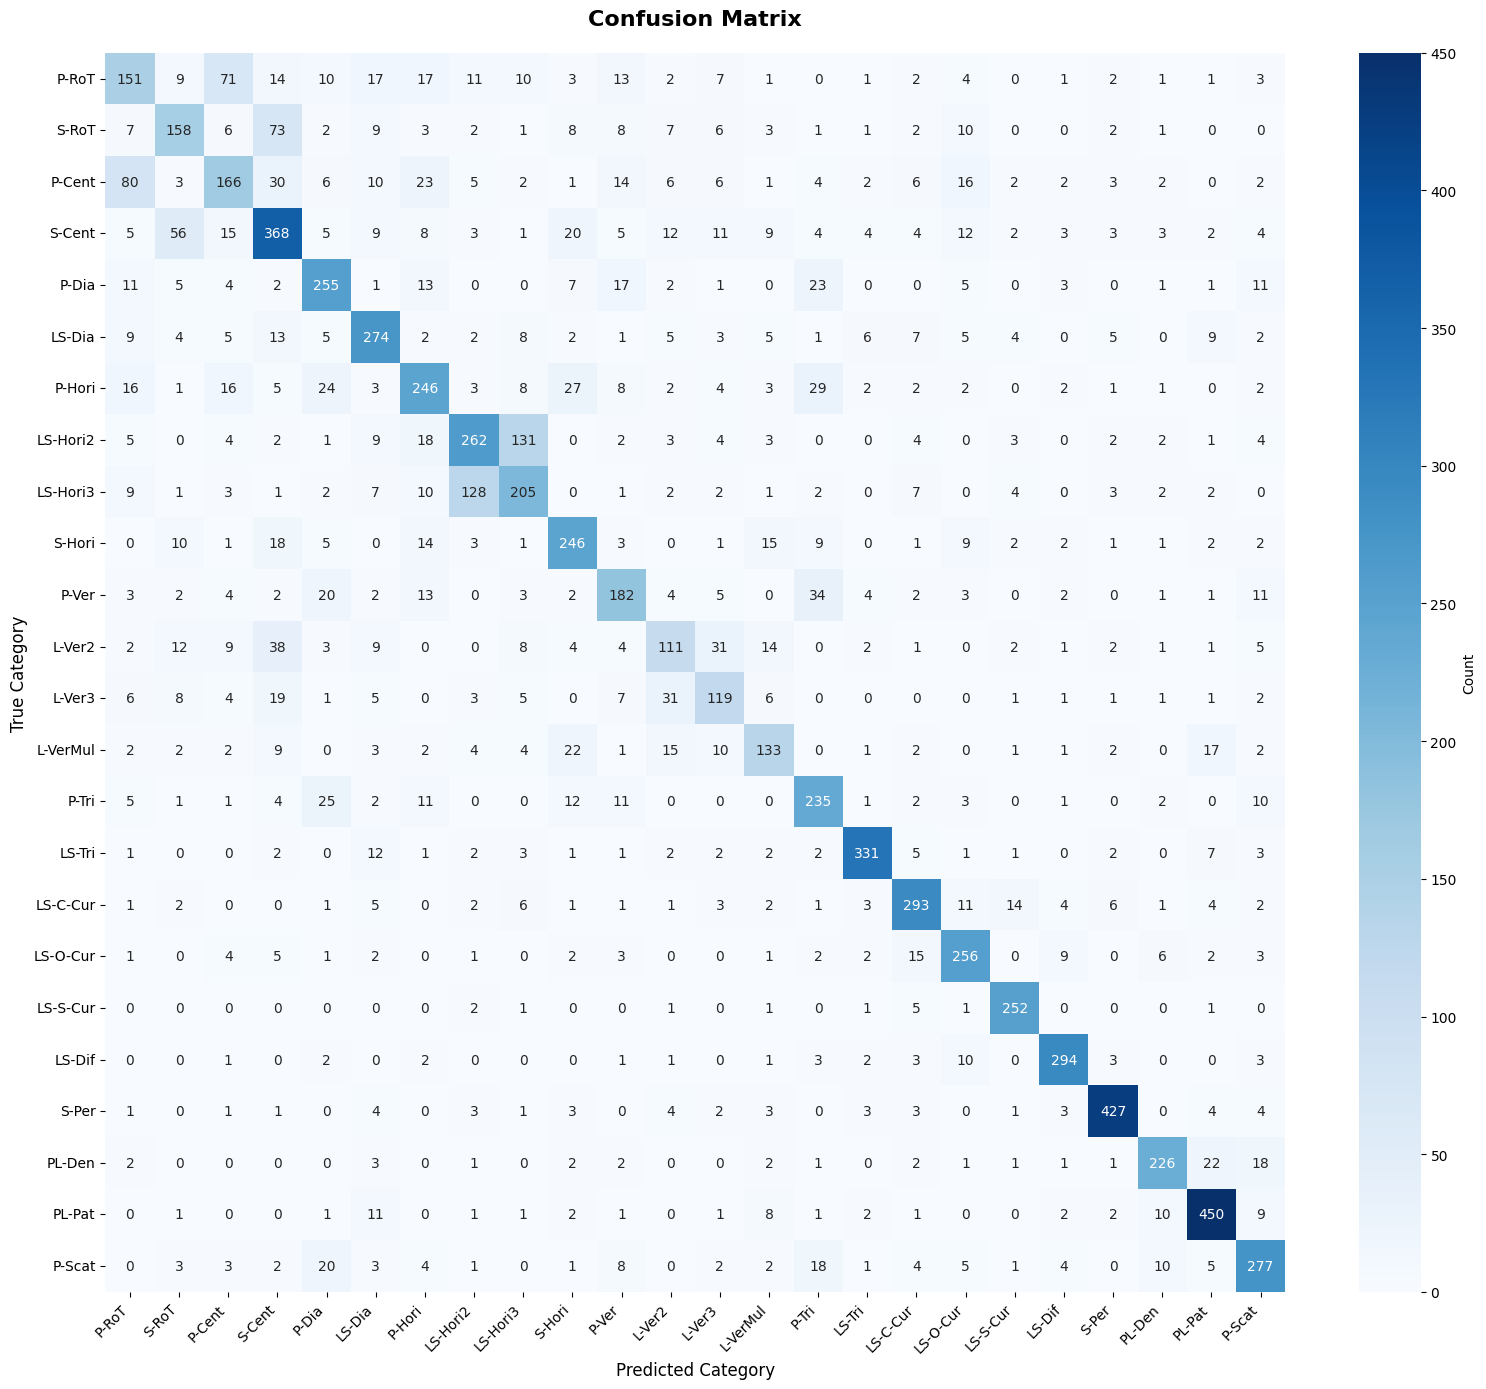


Calculating per-class metrics...

Per-Class Performance:
 Category ID Abbreviation                   Full Name  Count  Accuracy (%)
          19     LS-S-Cur                     S-Curve    265     95.094340
          21        S-Per                 Perspective    468     91.239316
          20       LS-Dif                     Diffuse    326     90.184049
          23       PL-Pat                     Pattern    504     89.285714
          16       LS-Tri         Line/Shape-Triangle    381     86.876640
          18     LS-O-Cur                     O-Curve    315     81.269841
          17     LS-C-Cur                     C-Curve    364     80.494505
          22       PL-Den               Random- Dense    285     79.298246
          24       P-Scat                     Scatter    374     74.064171
           6       LS-Dia       Diagonal Lines/Shapes    377     72.679045
          15        P-Tri       Three Points Triangle    326     72.085890
          10       S-Hori  Horizontal Arra

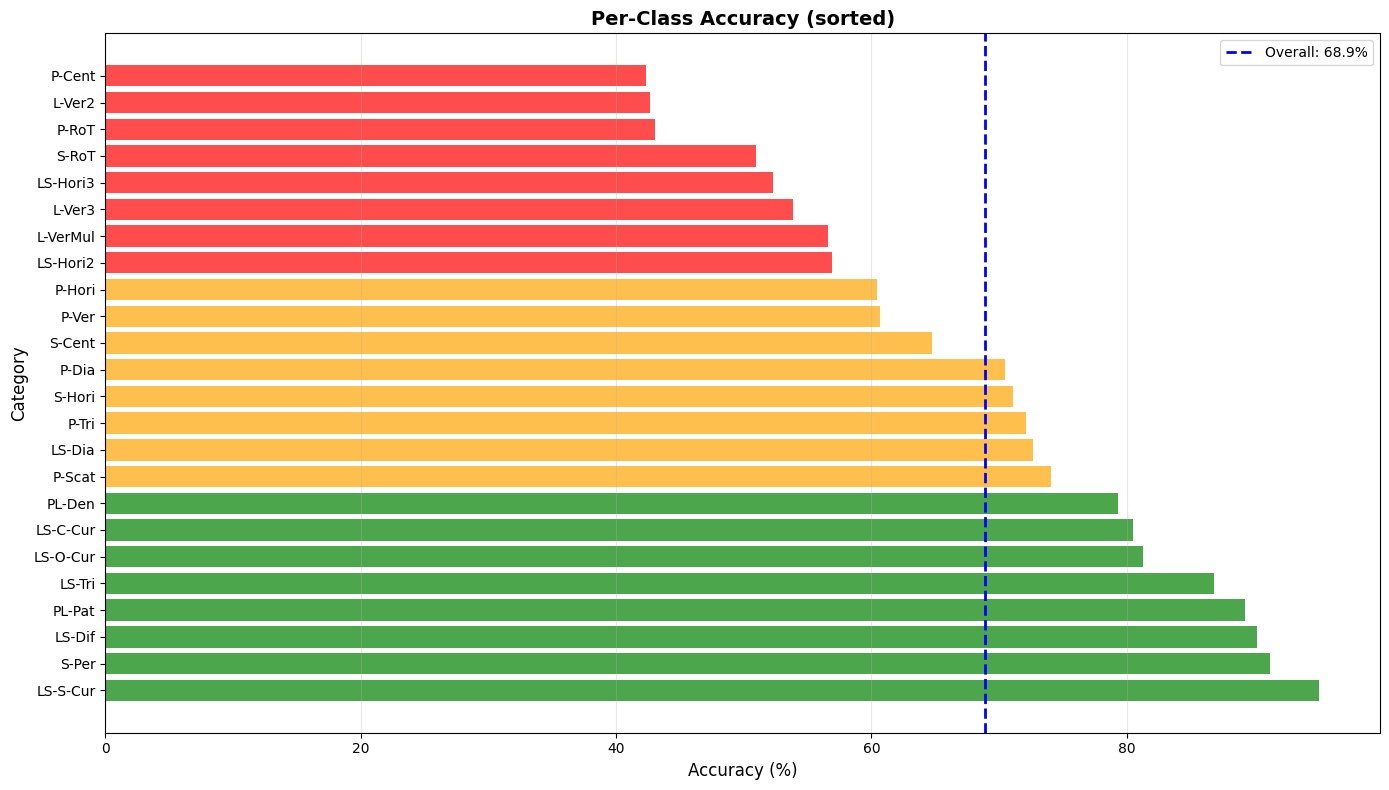


Finding most confused category pairs...

Top 15 Most Confused Pairs:
    True Predicted  Count
LS-Hori2  LS-Hori3    131
LS-Hori3  LS-Hori2    128
  P-Cent     P-RoT     80
   S-RoT    S-Cent     73
   P-RoT    P-Cent     71
  S-Cent     S-RoT     56
  L-Ver2    S-Cent     38
   P-Ver     P-Tri     34
  L-Ver3    L-Ver2     31
  L-Ver2    L-Ver3     31
  P-Cent    S-Cent     30
  P-Hori     P-Tri     29
  P-Hori    S-Hori     27
   P-Tri     P-Dia     25
  P-Hori     P-Dia     24
Saved: /scratch.global/kanth042/CV_project/confused_pairs.png


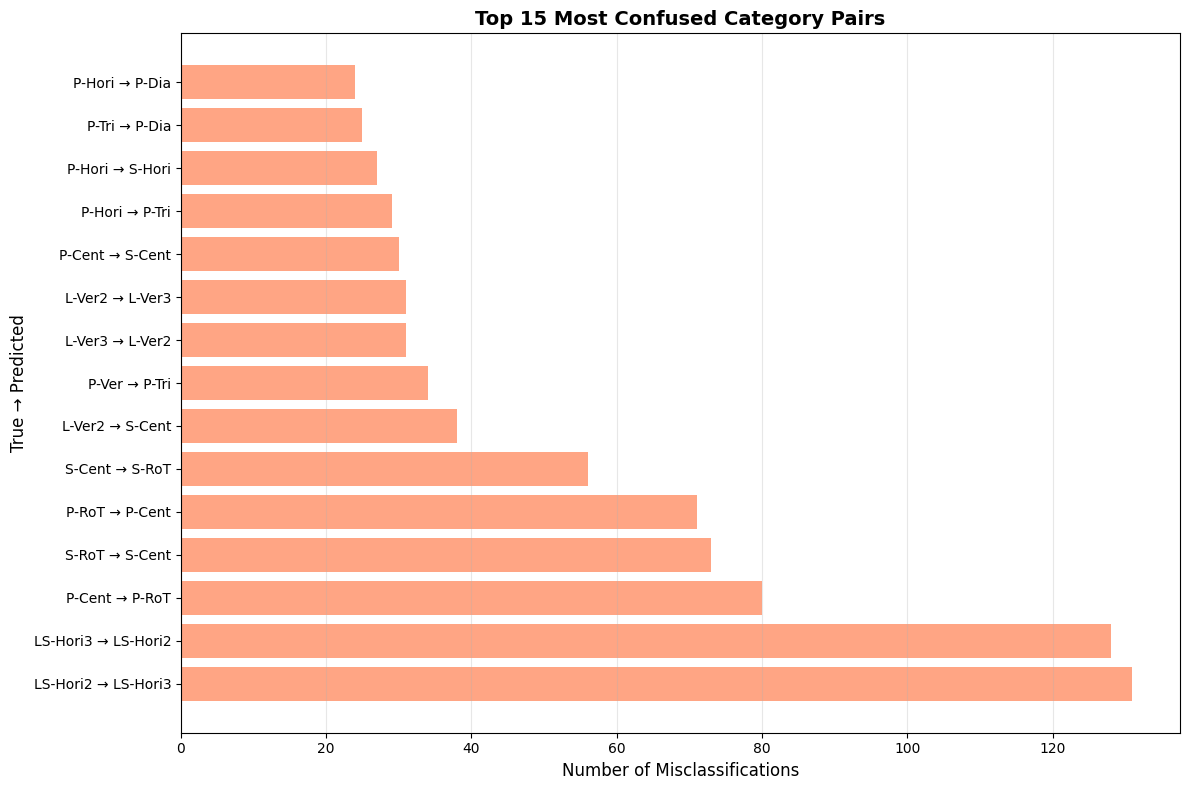


SUMMARY STATISTICS
Overall Accuracy: 68.89%
Best Class: LS-S-Cur (95.09%)
Worst Class: P-Cent (42.35%)
Classes above 75%: 8/24
Classes below 60%: 8/24

Detailed classification report saved: /scratch.global/kanth042/CV_project/classification_report.csv


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import json

# Set style
plt.style.use('default')
sns.set_palette("husl")

# 1. Load the trained model
class DINOClassifier(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        self.dino.eval()
        for param in self.dino.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.dino(x)
        logits = self.classifier(features)
        return logits

class PICDDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = Path(img_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row['folder_name'] / row['img_id']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['category_id']) - 1
        return image, label, row['img_id'], row['category_abbre']

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOCAL_DIR = '/scratch.global/kanth042/CV_project'

# Load model
print('Loading trained model...')
model = DINOClassifier(num_classes=24).to(device)
checkpoint = torch.load(f'{LOCAL_DIR}/best_dino_classifier.pth')
model.classifier.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded model from epoch {checkpoint['epoch']} with Val Acc: {checkpoint['val_acc']:.2f}%")

# Load training history
with open(f'{LOCAL_DIR}/training_history.json', 'r') as f:
    history = json.load(f)

# Load validation data
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = PICDDataset(f'{LOCAL_DIR}/val_split.csv', f'{LOCAL_DIR}/PICD', val_transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=8)

# Get category mapping
df = pd.read_csv(f'{LOCAL_DIR}/val_split.csv')
category_names = df[['category_id', 'category_abbre', 'category_full_name']].drop_duplicates().sort_values('category_id')
id_to_name = dict(zip(category_names['category_id']-1, category_names['category_abbre']))
id_to_full = dict(zip(category_names['category_id']-1, category_names['category_full_name']))

print(f'\nValidation set: {len(val_dataset)} images')
print('='*60)

# 2. Get predictions
print('\nGenerating predictions...')
all_preds = []
all_labels = []
all_img_ids = []
all_abbres = []

with torch.no_grad():
    for images, labels, img_ids, abbres in tqdm(val_loader, desc='Predicting'):
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_img_ids.extend(img_ids)
        all_abbres.extend(abbres)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall accuracy
accuracy = (all_preds == all_labels).mean() * 100
print(f'\nOverall Validation Accuracy: {accuracy:.2f}%')

# 3. Training Curves
print('\nPlotting training curves...')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{LOCAL_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
print(f'Saved: {LOCAL_DIR}/training_curves.png')
plt.show()

# 4. Confusion Matrix
print('\nGenerating confusion matrix...')
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id_to_name[i] for i in range(24)],
            yticklabels=[id_to_name[i] for i in range(24)],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{LOCAL_DIR}/confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f'Saved: {LOCAL_DIR}/confusion_matrix.png')
plt.show()

# 5. Per-class Accuracy
print('\nCalculating per-class metrics...')
class_accuracies = []
class_counts = []

for i in range(24):
    mask = all_labels == i
    if mask.sum() > 0:
        acc = (all_preds[mask] == all_labels[mask]).mean() * 100
        class_accuracies.append(acc)
        class_counts.append(mask.sum())
    else:
        class_accuracies.append(0)
        class_counts.append(0)

# Create DataFrame
results_df = pd.DataFrame({
    'Category ID': range(1, 25),
    'Abbreviation': [id_to_name[i] for i in range(24)],
    'Full Name': [id_to_full[i] for i in range(24)],
    'Count': class_counts,
    'Accuracy (%)': class_accuracies
})
results_df = results_df.sort_values('Accuracy (%)', ascending=False)

print('\nPer-Class Performance:')
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv(f'{LOCAL_DIR}/per_class_results.csv', index=False)
print(f'\nSaved: {LOCAL_DIR}/per_class_results.csv')

# Plot per-class accuracy
plt.figure(figsize=(14, 8))
colors = ['green' if acc >= 75 else 'orange' if acc >= 60 else 'red' for acc in results_df['Accuracy (%)']]
bars = plt.barh(results_df['Abbreviation'], results_df['Accuracy (%)'], color=colors, alpha=0.7)
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Per-Class Accuracy (sorted)', fontsize=14, fontweight='bold')
plt.axvline(x=accuracy, color='blue', linestyle='--', linewidth=2, label=f'Overall: {accuracy:.1f}%')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(f'{LOCAL_DIR}/per_class_accuracy.png', dpi=300, bbox_inches='tight')
print(f'Saved: {LOCAL_DIR}/per_class_accuracy.png')
plt.show()

# 6. Most Confused Pairs
print('\nFinding most confused category pairs...')
confused_pairs = []
for i in range(24):
    for j in range(24):
        if i != j:
            confused_pairs.append({
                'True': id_to_name[i],
                'Predicted': id_to_name[j],
                'Count': cm[i, j]
            })

confused_df = pd.DataFrame(confused_pairs).sort_values('Count', ascending=False).head(15)
print('\nTop 15 Most Confused Pairs:')
print(confused_df.to_string(index=False))

plt.figure(figsize=(12, 8))
pairs = [f"{row['True']} → {row['Predicted']}" for _, row in confused_df.iterrows()]
plt.barh(pairs, confused_df['Count'], color='coral', alpha=0.7)
plt.xlabel('Number of Misclassifications', fontsize=12)
plt.ylabel('True → Predicted', fontsize=12)
plt.title('Top 15 Most Confused Category Pairs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(f'{LOCAL_DIR}/confused_pairs.png', dpi=300, bbox_inches='tight')
print(f'Saved: {LOCAL_DIR}/confused_pairs.png')
plt.show()

# 7. Summary Statistics
print('\n' + '='*60)
print('SUMMARY STATISTICS')
print('='*60)
print(f'Overall Accuracy: {accuracy:.2f}%')
print(f'Best Class: {results_df.iloc[0]["Abbreviation"]} ({results_df.iloc[0]["Accuracy (%)"]:.2f}%)')
print(f'Worst Class: {results_df.iloc[-1]["Abbreviation"]} ({results_df.iloc[-1]["Accuracy (%)"]:.2f}%)')
print(f'Classes above 75%: {(results_df["Accuracy (%)"] >= 75).sum()}/24')
print(f'Classes below 60%: {(results_df["Accuracy (%)"] < 60).sum()}/24')

# Save detailed classification report
report = classification_report(all_labels, all_preds, 
                               target_names=[id_to_name[i] for i in range(24)],
                               output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f'{LOCAL_DIR}/classification_report.csv')
print(f'\nDetailed classification report saved: {LOCAL_DIR}/classification_report.csv')
print('='*60)


GROUPED CATEGORY ANALYSIS (10 Strategic Groups)

Grouped Accuracy (10 groups): 76.17%
Fine-grained Accuracy (24 categories): 68.89%
Improvement: +7.28%

Per-Group Performance:
 Group ID          Group Name Abbrev                         Categories  Count  Accuracy (%)
        7 Diffuse/Perspective   Diff                      LS-Dif, S-Per    794     91.561713
        8       Dense/Pattern  Dense                     PL-Den, PL-Pat    789     89.733840
        6              Curves  Curve       LS-C-Cur, LS-O-Cur, LS-S-Cur    944     89.724576
        3          Horizontal   Hori P-Hori, LS-Hori2, LS-Hori3, S-Hori   1605     81.121495
        5            Triangle    Tri                      P-Tri, LS-Tri    707     80.480905
        9             Scatter   Scat                             P-Scat    374     74.064171
        2            Diagonal   Diag                      P-Dia, LS-Dia    739     72.395129
        4            Vertical   Vert    P-Ver, L-Ver2, L-Ver3, L-VerMul   1016 

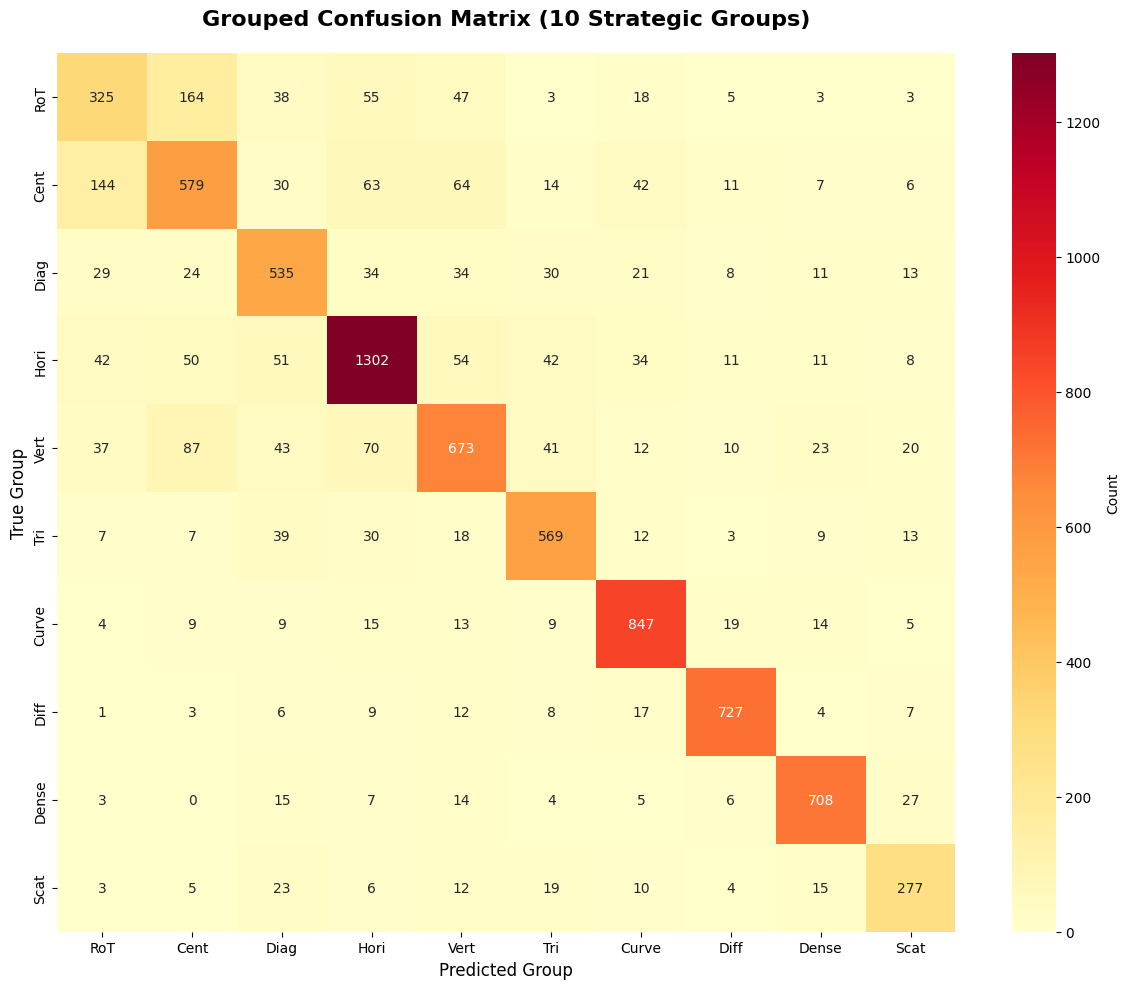

Saved: /scratch.global/kanth042/CV_project/accuracy_comparison.png


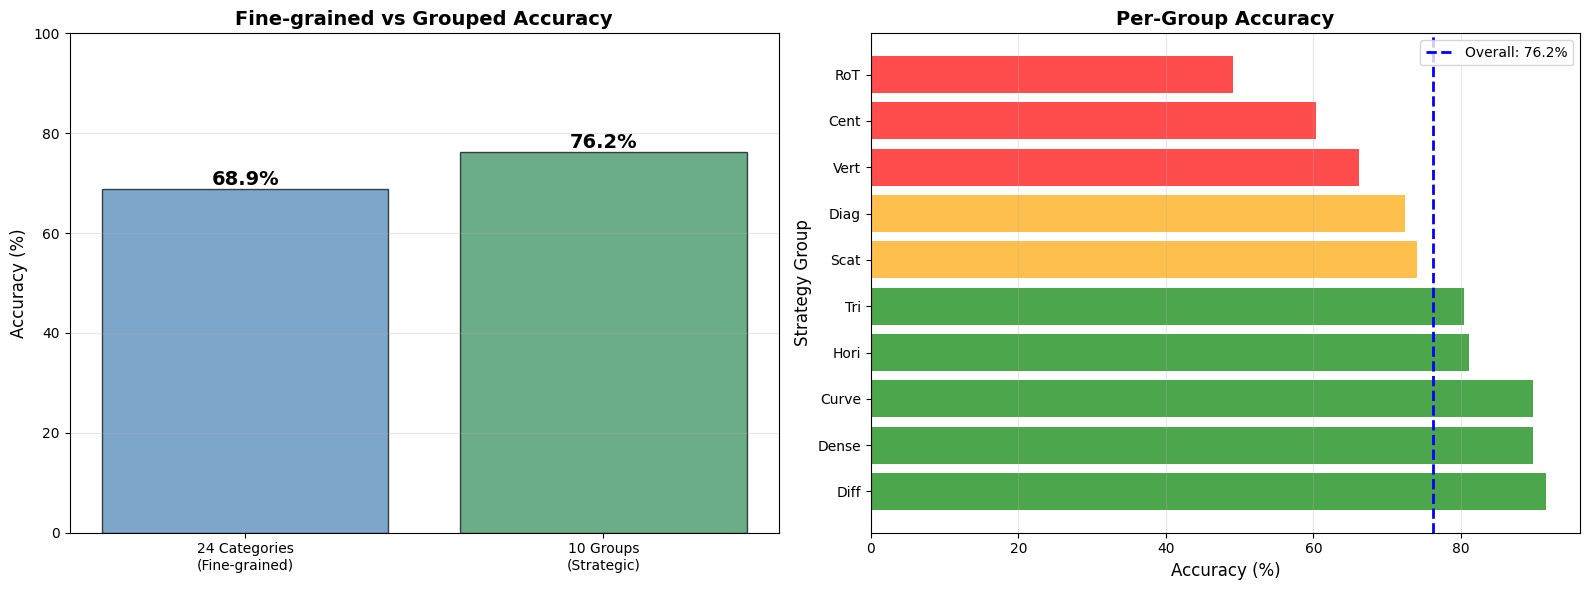


Analyzing within-group vs between-group confusion...

Confusion Analysis:
  Total predictions: 8589
  Correct group: 6542 (76.2%)
    └─ Exact category correct: 5917 (90.4% of correct group)
    └─ Wrong category in group: 625
  Wrong group: 2047 (23.8%)

WITHIN-GROUP CONFUSION ANALYSIS

Rule of Thirds Group (RoT):
  Categories: P-RoT, S-RoT
  Within-group accuracy: 95.1%
  Most confused pairs:
    P-RoT → S-RoT: 9
    S-RoT → P-RoT: 7

Centered Group (Cent):
  Categories: P-Cent, S-Cent
  Within-group accuracy: 92.2%
  Most confused pairs:
    P-Cent → S-Cent: 30
    S-Cent → P-Cent: 15

Diagonal Group (Diag):
  Categories: P-Dia, LS-Dia
  Within-group accuracy: 98.9%
  Most confused pairs:
    LS-Dia → P-Dia: 5
    P-Dia → LS-Dia: 1

Horizontal Group (Hori):
  Categories: P-Hori, LS-Hori2, LS-Hori3, S-Hori
  Within-group accuracy: 73.7%
  Most confused pairs:
    LS-Hori2 → LS-Hori3: 131
    LS-Hori3 → LS-Hori2: 128
    P-Hori → S-Hori: 27

Vertical Group (Vert):
  Categories: P-Ver

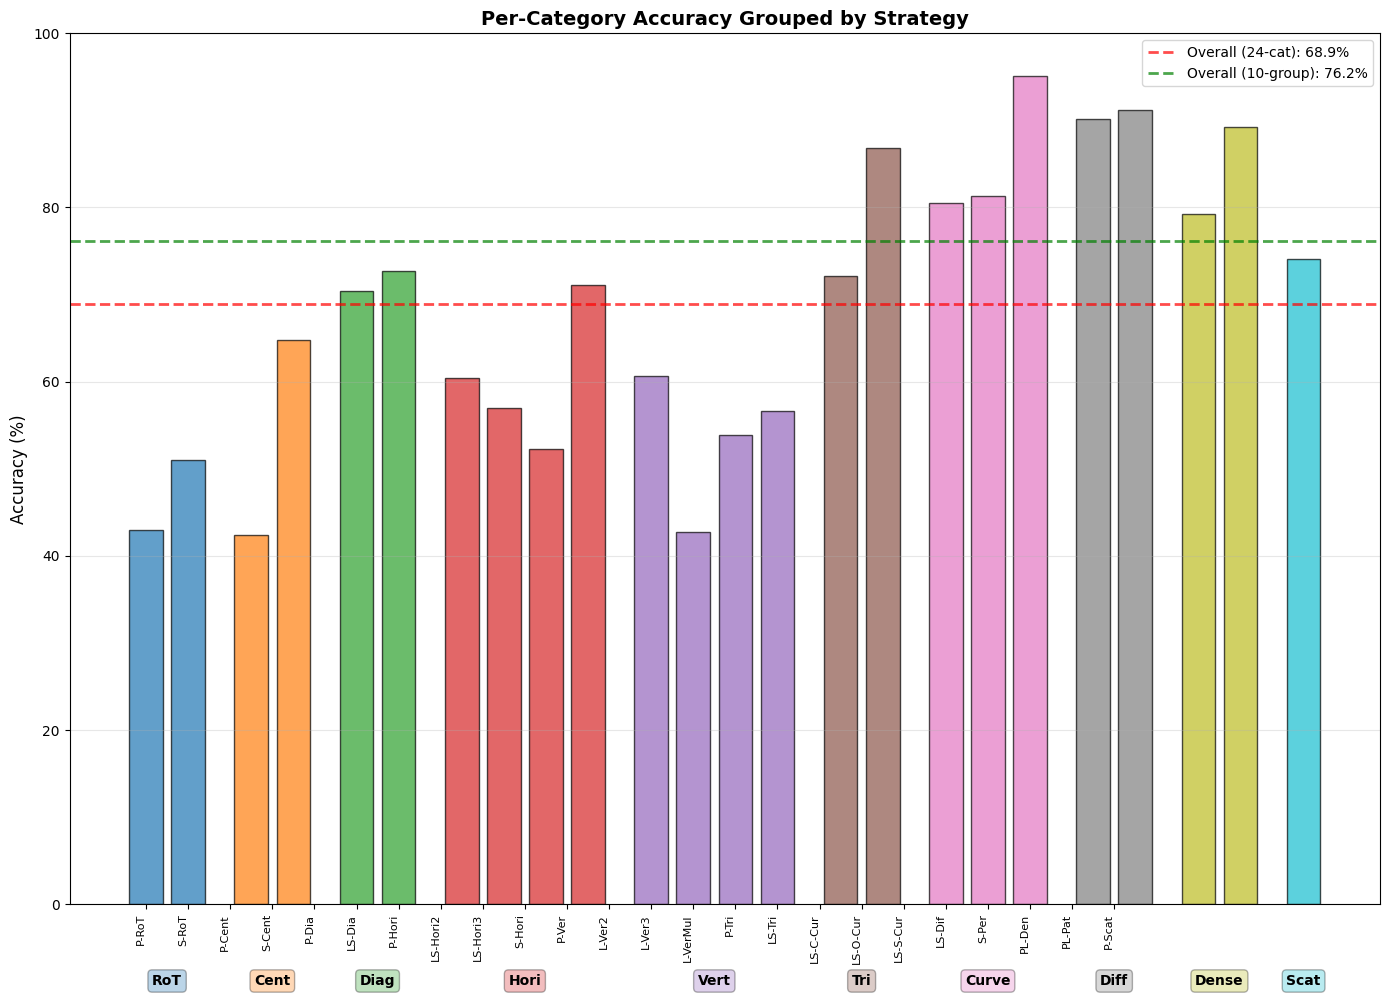


FINAL SUMMARY

24-Category Classification:
  Accuracy: 68.89%
  Best: LS-S-Cur (95.1%)
  Worst: P-Cent (42.3%)

10-Group Strategic Classification:
  Accuracy: 76.17%
  Improvement: +7.28%
  Best: Diff - Diffuse/Perspective (91.6%)
  Worst: RoT - Rule of Thirds (49.2%)

For Seam Carving Application:
  ✓ Using 10 strategic groups is recommended
  ✓ 76.2% accuracy is sufficient for composition-aware energy function
  ✓ Within-group confusions won't affect seam carving (same strategy)

Complete analysis saved to: /scratch.global/kanth042/CV_project/grouped_analysis_summary.json


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import json

# ... (keep your existing setup code) ...

# ============================================================
# NEW: DEFINE 10 STRATEGIC GROUPS
# ============================================================

# Mapping from 24 categories to 10 strategy groups
CATEGORY_TO_GROUP = {
    1: 0,   # P-RoT → Rule of Thirds
    2: 0,   # S-RoT → Rule of Thirds
    3: 1,   # P-Cent → Centered
    4: 1,   # S-Cent → Centered
    5: 2,   # P-Dia → Diagonal
    6: 2,   # LS-Dia → Diagonal
    7: 3,   # P-Hori → Horizontal
    8: 3,   # S-Hori → Horizontal
    9: 3,   # LS-Hori3 → Horizontal
    10: 3,  # LS-Hori2 → Horizontal
    11: 4,  # P-Ver → Vertical
    12: 4,  # L-Ver2 → Vertical
    13: 4,  # L-Ver3 → Vertical
    14: 4,  # L-Ver-mul → Vertical
    15: 5,  # P-Tri → Triangle
    16: 5,  # LS-Tri → Triangle
    17: 6,  # LS-C-Cur → Curves
    18: 6,  # LS-O-Cur → Curves
    19: 6,  # LS-S-Cur → Curves
    20: 7,  # LS-Dif → Diffuse/Perspective
    21: 7,  # S-Per → Diffuse/Perspective
    22: 8,  # PL-Den → Dense/Pattern
    23: 8,  # PL-Pat → Dense/Pattern
    24: 9,  # P-Scat → Scatter
}

GROUP_NAMES = {
    0: "Rule of Thirds",
    1: "Centered",
    2: "Diagonal",
    3: "Horizontal",
    4: "Vertical",
    5: "Triangle",
    6: "Curves",
    7: "Diffuse/Perspective",
    8: "Dense/Pattern",
    9: "Scatter"
}

GROUP_ABBREV = {
    0: "RoT",
    1: "Cent",
    2: "Diag",
    3: "Hori",
    4: "Vert",
    5: "Tri",
    6: "Curve",
    7: "Diff",
    8: "Dense",
    9: "Scat"
}

# Category to group mapping (0-indexed for model output)
def cat_to_group(cat_id):
    """Convert category ID (0-indexed) to group ID"""
    return CATEGORY_TO_GROUP[cat_id + 1]

# ... (keep your existing code until after you get predictions) ...

# After getting all_preds and all_labels:

print("\n" + "="*70)
print("GROUPED CATEGORY ANALYSIS (10 Strategic Groups)")
print("="*70)

# Map predictions and labels to groups
all_preds_grouped = np.array([cat_to_group(p) for p in all_preds])
all_labels_grouped = np.array([cat_to_group(l) for l in all_labels])

# Calculate grouped accuracy
grouped_accuracy = (all_preds_grouped == all_labels_grouped).mean() * 100
print(f"\nGrouped Accuracy (10 groups): {grouped_accuracy:.2f}%")
print(f"Fine-grained Accuracy (24 categories): {accuracy:.2f}%")
print(f"Improvement: +{grouped_accuracy - accuracy:.2f}%")

# Per-group accuracy
print("\nPer-Group Performance:")
group_results = []
for group_id in range(10):
    mask = all_labels_grouped == group_id
    if mask.sum() > 0:
        group_acc = (all_preds_grouped[mask] == all_labels_grouped[mask]).mean() * 100
        group_count = mask.sum()
        
        # Find which original categories belong to this group
        orig_cats = [k-1 for k, v in CATEGORY_TO_GROUP.items() if v == group_id]
        cat_names = [id_to_name[c] for c in orig_cats]
        
        group_results.append({
            'Group ID': group_id,
            'Group Name': GROUP_NAMES[group_id],
            'Abbrev': GROUP_ABBREV[group_id],
            'Categories': ', '.join(cat_names),
            'Count': group_count,
            'Accuracy (%)': group_acc
        })

group_df = pd.DataFrame(group_results).sort_values('Accuracy (%)', ascending=False)
print(group_df.to_string(index=False))

# Save grouped results
group_df.to_csv(f'{LOCAL_DIR}/grouped_results.csv', index=False)
print(f"\nSaved: {LOCAL_DIR}/grouped_results.csv")

# ============================================================
# VISUALIZATIONS FOR GROUPED ANALYSIS
# ============================================================

# 1. Grouped Confusion Matrix
print("\nGenerating grouped confusion matrix...")
cm_grouped = confusion_matrix(all_labels_grouped, all_preds_grouped)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_grouped, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=[GROUP_ABBREV[i] for i in range(10)],
            yticklabels=[GROUP_ABBREV[i] for i in range(10)],
            cbar_kws={'label': 'Count'})
plt.title('Grouped Confusion Matrix (10 Strategic Groups)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Group', fontsize=12)
plt.ylabel('True Group', fontsize=12)
plt.tight_layout()
plt.savefig(f'{LOCAL_DIR}/confusion_matrix_grouped.png', dpi=300, bbox_inches='tight')
print(f"Saved: {LOCAL_DIR}/confusion_matrix_grouped.png")
plt.show()

# 2. Comparison: Fine vs Grouped Accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot comparison
categories_list = ['24 Categories\n(Fine-grained)', '10 Groups\n(Strategic)']
accuracies_list = [accuracy, grouped_accuracy]
colors_list = ['steelblue', 'seagreen']

bars = axes[0].bar(categories_list, accuracies_list, color=colors_list, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Fine-grained vs Grouped Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies_list):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.1f}%',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Per-group accuracy bars
axes[1].barh(group_df['Abbrev'], group_df['Accuracy (%)'], 
            color=['green' if x >= 80 else 'orange' if x >= 70 else 'red' 
                   for x in group_df['Accuracy (%)']], alpha=0.7)
axes[1].set_xlabel('Accuracy (%)', fontsize=12)
axes[1].set_ylabel('Strategy Group', fontsize=12)
axes[1].set_title('Per-Group Accuracy', fontsize=14, fontweight='bold')
axes[1].axvline(x=grouped_accuracy, color='blue', linestyle='--', 
               linewidth=2, label=f'Overall: {grouped_accuracy:.1f}%')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{LOCAL_DIR}/accuracy_comparison.png', dpi=300, bbox_inches='tight')
print(f"Saved: {LOCAL_DIR}/accuracy_comparison.png")
plt.show()

# 3. Within-group vs Between-group confusion
print("\nAnalyzing within-group vs between-group confusion...")

within_group_correct = 0
within_group_total = 0
between_group_errors = 0

for i in range(len(all_labels)):
    true_cat = all_labels[i]
    pred_cat = all_preds[i]
    true_group = all_labels_grouped[i]
    pred_group = all_preds_grouped[i]
    
    if true_group == pred_group:
        within_group_total += 1
        if true_cat == pred_cat:
            within_group_correct += 1
    else:
        between_group_errors += 1

within_group_acc = (within_group_correct / within_group_total * 100) if within_group_total > 0 else 0

print(f"\nConfusion Analysis:")
print(f"  Total predictions: {len(all_labels)}")
print(f"  Correct group: {within_group_total} ({within_group_total/len(all_labels)*100:.1f}%)")
print(f"    └─ Exact category correct: {within_group_correct} ({within_group_acc:.1f}% of correct group)")
print(f"    └─ Wrong category in group: {within_group_total - within_group_correct}")
print(f"  Wrong group: {between_group_errors} ({between_group_errors/len(all_labels)*100:.1f}%)")

# 4. Show which categories within each group are confused
print("\n" + "="*70)
print("WITHIN-GROUP CONFUSION ANALYSIS")
print("="*70)

for group_id in range(10):
    # Get categories in this group
    orig_cats = [k-1 for k, v in CATEGORY_TO_GROUP.items() if v == group_id]
    
    if len(orig_cats) <= 1:
        continue  # Skip single-category groups
    
    print(f"\n{GROUP_NAMES[group_id]} Group ({GROUP_ABBREV[group_id]}):")
    print(f"  Categories: {', '.join([id_to_name[c] for c in orig_cats])}")
    
    # Find confusions within this group
    within_group_cm = np.zeros((len(orig_cats), len(orig_cats)), dtype=int)
    
    for i, true_cat in enumerate(orig_cats):
        for j, pred_cat in enumerate(orig_cats):
            count = cm[true_cat, pred_cat]
            within_group_cm[i, j] = count
    
    # Show confusion matrix if there are confusions
    if len(orig_cats) > 1:
        total_samples = within_group_cm.sum()
        correct = np.diag(within_group_cm).sum()
        within_acc = correct / total_samples * 100 if total_samples > 0 else 0
        
        print(f"  Within-group accuracy: {within_acc:.1f}%")
        
        # Show most confused pairs
        confusions = []
        for i, true_cat in enumerate(orig_cats):
            for j, pred_cat in enumerate(orig_cats):
                if i != j and within_group_cm[i, j] > 0:
                    confusions.append((id_to_name[true_cat], 
                                     id_to_name[pred_cat], 
                                     within_group_cm[i, j]))
        
        if confusions:
            confusions.sort(key=lambda x: x[2], reverse=True)
            print("  Most confused pairs:")
            for true, pred, count in confusions[:3]:
                print(f"    {true} → {pred}: {count}")

# 5. Create mapping visualization
print("\nCreating category-to-group mapping visualization...")

fig, ax = plt.subplots(figsize=(14, 10))

# Prepare data for visualization
mapping_data = []
for cat_id in range(24):
    group_id = cat_to_group(cat_id)
    mapping_data.append({
        'category': id_to_name[cat_id],
        'group': GROUP_ABBREV[group_id],
        'cat_acc': class_accuracies[cat_id],
        'group_id': group_id
    })

mapping_df = pd.DataFrame(mapping_data)

# Create grouped bar plot
group_positions = {}
current_pos = 0
for group_id in range(10):
    group_cats = mapping_df[mapping_df['group_id'] == group_id]
    n_cats = len(group_cats)
    positions = np.arange(current_pos, current_pos + n_cats)
    group_positions[group_id] = (current_pos, current_pos + n_cats - 1)
    
    colors = plt.cm.tab10(group_id)
    ax.bar(positions, group_cats['cat_acc'], color=colors, alpha=0.7, edgecolor='black')
    
    current_pos += n_cats + 0.5  # Add spacing between groups

# Add group labels
for group_id, (start, end) in group_positions.items():
    mid = (start + end) / 2
    ax.text(mid, -8, GROUP_ABBREV[group_id], 
           ha='center', va='top', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor=plt.cm.tab10(group_id), alpha=0.3))

# Category labels
all_cats = [d['category'] for d in mapping_data]
ax.set_xticks(range(len(all_cats)))
ax.set_xticklabels(all_cats, rotation=90, ha='right', fontsize=8)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Category Accuracy Grouped by Strategy', fontsize=14, fontweight='bold')
ax.axhline(y=accuracy, color='red', linestyle='--', linewidth=2, 
          label=f'Overall (24-cat): {accuracy:.1f}%', alpha=0.7)
ax.axhline(y=grouped_accuracy, color='green', linestyle='--', linewidth=2, 
          label=f'Overall (10-group): {grouped_accuracy:.1f}%', alpha=0.7)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 100])

plt.tight_layout()
plt.savefig(f'{LOCAL_DIR}/category_to_group_mapping.png', dpi=300, bbox_inches='tight')
print(f"Saved: {LOCAL_DIR}/category_to_group_mapping.png")
plt.show()

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\n24-Category Classification:")
print(f"  Accuracy: {accuracy:.2f}%")
print(f"  Best: {results_df.iloc[0]['Abbreviation']} ({results_df.iloc[0]['Accuracy (%)']:.1f}%)")
print(f"  Worst: {results_df.iloc[-1]['Abbreviation']} ({results_df.iloc[-1]['Accuracy (%)']:.1f}%)")

print(f"\n10-Group Strategic Classification:")
print(f"  Accuracy: {grouped_accuracy:.2f}%")
print(f"  Improvement: +{grouped_accuracy - accuracy:.2f}%")
print(f"  Best: {group_df.iloc[0]['Abbrev']} - {group_df.iloc[0]['Group Name']} ({group_df.iloc[0]['Accuracy (%)']:.1f}%)")
print(f"  Worst: {group_df.iloc[-1]['Abbrev']} - {group_df.iloc[-1]['Group Name']} ({group_df.iloc[-1]['Accuracy (%)']:.1f}%)")

print(f"\nFor Seam Carving Application:")
print(f"  ✓ Using 10 strategic groups is recommended")
print(f"  ✓ {grouped_accuracy:.1f}% accuracy is sufficient for composition-aware energy function")
print(f"  ✓ Within-group confusions won't affect seam carving (same strategy)")

# Save complete analysis
analysis_summary = {
    'fine_grained_accuracy': float(accuracy),
    'grouped_accuracy': float(grouped_accuracy),
    'improvement': float(grouped_accuracy - accuracy),
    'within_group_accuracy': float(within_group_acc),
    'between_group_error_rate': float(between_group_errors / len(all_labels) * 100),
    'group_results': group_df.to_dict('records')
}

with open(f'{LOCAL_DIR}/grouped_analysis_summary.json', 'w') as f:
    json.dump(analysis_summary, f, indent=2)

print(f"\nComplete analysis saved to: {LOCAL_DIR}/grouped_analysis_summary.json")
print("="*70)

In [6]:
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import label, gaussian_filter1d, uniform_filter
from skimage.measure import regionprops
from scipy.signal import find_peaks
import pandas as pd
import numba as nb

# ============================================================
# OPTIMIZED SEAM CARVING (Your numba implementation)
# ============================================================

@nb.njit(nb.int32[:](nb.float32[:, :]), cache=True)
def _get_backward_seam(energy: np.ndarray) -> np.ndarray:
    """Numba-optimized DP for backward energy"""
    h, w = energy.shape
    inf = np.array([np.inf], dtype=np.float32)
    cost = np.concatenate((inf, energy[0], inf))
    parent = np.empty((h, w), dtype=np.int32)
    base_idx = np.arange(-1, w - 1, dtype=np.int32)

    for r in range(1, h):
        choices = np.vstack((cost[:-2], cost[1:-1], cost[2:]))
        min_idx = np.argmin(choices, axis=0) + base_idx
        parent[r] = min_idx
        cost[1:-1] = cost[1:-1][min_idx] + energy[r]

    c = np.argmin(cost[1:-1])
    seam = np.empty(h, dtype=np.int32)
    for r in range(h - 1, -1, -1):
        seam[r] = c
        c = parent[r, c]

    return seam

def _get_seam_mask(src: np.ndarray, seam: np.ndarray) -> np.ndarray:
    """Convert seam indices to mask"""
    return np.eye(src.shape[1], dtype=bool)[seam]

def _remove_seam_mask(src: np.ndarray, seam_mask: np.ndarray) -> np.ndarray:
    """Remove seam using mask"""
    if src.ndim == 3:
        h, w, c = src.shape
        seam_mask = np.broadcast_to(seam_mask[:, :, None], src.shape)
        dst = src[~seam_mask].reshape((h, w - 1, c))
    else:
        h, w = src.shape
        dst = src[~seam_mask].reshape((h, w - 1))
    return dst

def _get_energy_gradient(gray: np.ndarray) -> np.ndarray:
    """Sobel gradient energy"""
    from scipy.ndimage import sobel
    gray = gray.astype(np.float32)
    grad_x = sobel(gray, axis=1)
    grad_y = sobel(gray, axis=0)
    energy = np.abs(grad_x) + np.abs(grad_y)
    return energy

# ============================================================
# COMPOSITION-AWARE ENERGY (Integrated with your code)
# ============================================================

CATEGORY_TO_GROUP = {
    0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 3,
    10: 4, 11: 4, 12: 4, 13: 4, 14: 5, 15: 5, 16: 6, 17: 6, 18: 6,
    19: 7, 20: 7, 21: 8, 22: 8, 23: 9
}

GROUP_NAMES = [
    "Rule of Thirds", "Centered", "Diagonal", "Horizontal",
    "Vertical", "Triangle", "Curves", "Diffuse/Perspective",
    "Dense/Pattern", "Scatter"
]

class CompositionAwareEnergy:
    def __init__(self, image, importance_map, group_id):
        self.image = image
        self.importance_map = importance_map
        self.group_id = group_id
        self.h, self.w = image.shape[:2]
        self.fg_center = self._fg_center()
    
    def _fg_center(self):
        threshold = np.percentile(self.importance_map, 75)
        binary = (self.importance_map > threshold).astype(np.uint8)
        labeled, n = label(binary)
        if n == 0:
            return (self.h // 2, self.w // 2)
        sizes = np.bincount(labeled.ravel())
        sizes[0] = 0
        largest = sizes.argmax()
        props = regionprops((labeled == largest).astype(int))
        if props:
            cy, cx = props[0].centroid
            return (int(cy), int(cx))
        return (self.h // 2, self.w // 2)
    
    def get_aux_energy(self, target_width=None):
        """Returns aux_energy that will be ADDED to gradient energy"""
        # Start with importance as base (inverted: high importance = high aux energy = preserve)
        aux_energy = self.importance_map.copy().astype(np.float32)
        
        # Apply group-specific weights
        if self.group_id == 0:  # RoT
            cy, cx = self.fg_center
            if target_width:
                power_points = [(self.h//3, target_width//3), (self.h//3, 2*target_width//3),
                               (2*self.h//3, target_width//3), (2*self.h//3, 2*target_width//3)]
                dists = [np.sqrt((cy-py)**2 + (cx-px)**2) for py, px in power_points]
                _, target_px = power_points[np.argmin(dists)]
                # Reduce on side to remove
                if cx < target_px:
                    aux_energy[:, :cx] *= 0.3
                else:
                    aux_energy[:, cx:] *= 0.3
            # Boost foreground
            y1, y2 = max(0, cy-50), min(self.h, cy+50)
            x1, x2 = max(0, cx-50), min(self.w, cx+50)
            aux_energy[y1:y2, x1:x2] *= 3.0
            
        elif self.group_id == 1:  # Centered
            cy, cx = self.fg_center
            Y, X = np.mgrid[:self.h, :self.w]
            dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
            aux_energy[dist < min(self.h, self.w)//4] *= 4.0
            aux_energy[:, :cx//2] *= 0.5
            aux_energy[:, (cx+self.w)//2:] *= 0.5
            
        elif self.group_id == 3:  # Horizontal
            imp_vert = self.importance_map.mean(axis=1)
            grad = np.abs(np.gradient(imp_vert))
            grad_smooth = gaussian_filter1d(grad, sigma=5)
            mid_start, mid_end = self.h//4, 3*self.h//4
            horizon_y = mid_start + np.argmax(grad_smooth[mid_start:mid_end])
            aux_energy[max(0, horizon_y-20):min(self.h, horizon_y+20), :] *= 2.5
        
        # Scale to reasonable range (will be added to gradient energy)
        aux_energy = aux_energy * 100  # Scale factor
        
        return aux_energy

# ============================================================
# FAST SEAM CARVING
# ============================================================

def seam_carve_fast(image, importance_map, group_id, target_width):
    """Fast seam carving using your optimized code"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32)
    h, w = gray.shape
    num_seams = w - target_width
    
    # Get composition-aware auxiliary energy
    energy_fn = CompositionAwareEnergy(image, importance_map, group_id)
    aux_energy = energy_fn.get_aux_energy(target_width)
    
    # Track seams to remove
    seams_mask = np.zeros((h, w), dtype=bool)
    rows = np.arange(h, dtype=np.int32)
    idx_map = np.broadcast_to(np.arange(w, dtype=np.int32), (h, w))
    
    for _ in tqdm(range(num_seams), desc='Carving seams'):
        # Compute energy
        gradient_energy = _get_energy_gradient(gray)
        total_energy = gradient_energy + aux_energy
        
        # Find optimal seam
        seam = _get_backward_seam(total_energy.astype(np.float32))
        
        # Mark seam in original coordinates
        seams_mask[rows, idx_map[rows, seam]] = True
        
        # Remove seam from working images
        seam_mask = _get_seam_mask(gray, seam)
        gray = _remove_seam_mask(gray, seam_mask)
        idx_map = _remove_seam_mask(idx_map, seam_mask)
        aux_energy = _remove_seam_mask(aux_energy, seam_mask)
    
    # Apply mask to original image
    to_keep = ~seams_mask
    if image.ndim == 3:
        to_keep = np.broadcast_to(to_keep[:, :, None], image.shape)
        output = image[to_keep].reshape((h, target_width, image.shape[2]))
    else:
        output = image[to_keep].reshape((h, target_width))
    
    return output

# ============================================================
# DINO CLASSIFIER
# ============================================================

class DINOClassifier(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        self.dino.eval()
        for param in self.dino.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.dino(x)
        return self.classifier(features)

def detect_composition(image, model, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(Image.fromarray(image)).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(img_tensor)
        category = logits.argmax(dim=1).item()
    
    group_id = CATEGORY_TO_GROUP[category]
    return group_id, GROUP_NAMES[group_id], category

# ============================================================
# SAM2
# ============================================================

class SAM2ImportanceMap:
    def __init__(self):
        import torch
        from sam2.build_sam import build_sam2
        from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
        
        self.device = torch.device('cuda')
        checkpoint = "sam2_hiera_large.pt"
        config = "sam2_hiera_l.yaml"
        
        if not Path(checkpoint).exists():
            import subprocess
            print("Downloading SAM2...")
            subprocess.run(["wget", 
                "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"])
        
        sam2_model = build_sam2(config_file=config, ckpt_path=checkpoint, device=self.device)
        self.mask_generator = SAM2AutomaticMaskGenerator(
            model=sam2_model, points_per_side=24, points_per_batch=64,
            pred_iou_thresh=0.7, stability_score_thresh=0.92)
    
    def generate(self, image):
        masks = self.mask_generator.generate(image)
        importance = np.zeros(image.shape[:2], dtype=np.float32)
        for mask in masks:
            mask_array = mask['segmentation'].astype(float)
            weight = mask['stability_score'] * mask['predicted_iou'] * \
                    (mask['area'] / (image.shape[0] * image.shape[1]))
            importance += mask_array * weight
        if importance.max() > 0:
            importance = (importance - importance.min()) / (importance.max() - importance.min())
        return importance

# ============================================================
# MAIN
# ============================================================

def process_single_image(image_path, output_path, composition_model, sam_model, device, 
                        target_width=None):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    if target_width is None:
        target_width = int (w // 1.1)
    
    # Detect composition
    group_id, group_name, category = detect_composition(image, composition_model, device)
    print(f"Detected: {group_name} (group {group_id}, category {category})")
    
    # SAM importance
    print("Generating importance map...")
    importance_map = sam_model.generate(image)
    importance_map = cv2.resize(importance_map, (w, h))
    
    # Fast carving
    print(f"Resizing from {w}x{h} to {target_width}x{h}")
    resized = seam_carve_fast(image, importance_map, group_id, target_width)
    
    # Save
    cv2.imwrite(str(output_path), cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))
    print(f"Saved: {output_path}")

if __name__ == '__main__':
    device = torch.device('cuda')
    
    print("Loading DINO classifier...")
    composition_model = DINOClassifier(num_classes=24).to(device)
    checkpoint = torch.load('/scratch.global/kanth042/CV_project/best_dino_classifier.pth')
    composition_model.classifier.load_state_dict(checkpoint['model_state_dict'])
    composition_model.eval()
    
    print("Loading SAM2...")
    sam_model = SAM2ImportanceMap()
    
    process_single_image(
        image_path='PruneRepaint/RetargetMe/bike/bike.png',
        output_path='output.jpg',
        composition_model=composition_model,
        sam_model=sam_model,
        device=device
    )

Loading DINO classifier...


Using cache found in /users/7/kanth042/.cache/torch/hub/facebookresearch_dinov2_main


Loading SAM2...
Detected: Centered (group 1, category 3)
Generating importance map...
Resizing from 615x409 to 559x409


Carving seams: 100%|██████████| 56/56 [00:00<00:00, 175.69it/s]

Saved: output.jpg


In [11]:
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import label, gaussian_filter1d, uniform_filter, sobel
from skimage.measure import regionprops
from scipy.signal import find_peaks
import pandas as pd
import numba as nb

# ============================================================
# NUMBA-OPTIMIZED SEAM CARVING
# ============================================================

@nb.njit(nb.int32[:](nb.float32[:, :]), cache=True)
def _get_backward_seam(energy: np.ndarray) -> np.ndarray:
    """Numba-optimized DP for backward energy"""
    h, w = energy.shape
    inf = np.array([np.inf], dtype=np.float32)
    cost = np.concatenate((inf, energy[0], inf))
    parent = np.empty((h, w), dtype=np.int32)
    base_idx = np.arange(-1, w - 1, dtype=np.int32)

    for r in range(1, h):
        choices = np.vstack((cost[:-2], cost[1:-1], cost[2:]))
        min_idx = np.argmin(choices, axis=0) + base_idx
        parent[r] = min_idx
        cost[1:-1] = cost[1:-1][min_idx] + energy[r]

    c = np.argmin(cost[1:-1])
    seam = np.empty(h, dtype=np.int32)
    for r in range(h - 1, -1, -1):
        seam[r] = c
        c = parent[r, c]

    return seam

def _get_seam_mask(src: np.ndarray, seam: np.ndarray) -> np.ndarray:
    """Convert seam indices to mask"""
    return np.eye(src.shape[1], dtype=bool)[seam]

def _remove_seam_mask(src: np.ndarray, seam_mask: np.ndarray) -> np.ndarray:
    """Remove seam using mask"""
    if src.ndim == 3:
        h, w, c = src.shape
        seam_mask = np.broadcast_to(seam_mask[:, :, None], src.shape)
        dst = src[~seam_mask].reshape((h, w - 1, c))
    else:
        h, w = src.shape
        dst = src[~seam_mask].reshape((h, w - 1))
    return dst

def _get_energy_gradient(gray: np.ndarray) -> np.ndarray:
    """Sobel gradient energy"""
    gray = gray.astype(np.float32)
    grad_x = sobel(gray, axis=1)
    grad_y = sobel(gray, axis=0)
    energy = np.abs(grad_x) + np.abs(grad_y)
    return energy

# ============================================================
# COMPOSITION GROUPS
# ============================================================

CATEGORY_TO_GROUP = {
    0: 0, 1: 0,           # P-RoT, S-RoT → Rule of Thirds
    2: 1, 3: 1,           # P-Cent, S-Cent → Centered
    4: 2, 5: 2,           # P-Dia, LS-Dia → Diagonal
    6: 3, 7: 3, 8: 3, 9: 3,   # P-Hori, S-Hori, LS-Hori3, LS-Hori2 → Horizontal
    10: 4, 11: 4, 12: 4, 13: 4,  # P-Ver, L-Ver2, L-Ver3, L-VerMul → Vertical
    14: 5, 15: 5,         # P-Tri, LS-Tri → Triangle
    16: 6, 17: 6, 18: 6,  # LS-C-Cur, LS-O-Cur, LS-S-Cur → Curves
    19: 7, 20: 7,         # LS-Dif, S-Per → Diffuse/Perspective
    21: 8, 22: 8,         # PL-Den, PL-Pat → Dense/Pattern
    23: 9                 # P-Scat → Scatter
}

GROUP_NAMES = [
    "Rule of Thirds", "Centered", "Diagonal", "Horizontal",
    "Vertical", "Triangle", "Curves", "Diffuse/Perspective",
    "Dense/Pattern", "Scatter"
]

# ============================================================
# COMPOSITION-AWARE ENERGY - ALL 10 GROUPS
# ============================================================

class CompositionAwareEnergy:
    def __init__(self, image, importance_map, group_id):
        self.image = image
        self.importance_map = importance_map
        self.group_id = group_id
        self.h, self.w = image.shape[:2]
        self.fg_center = self._find_fg_center()
        self.fg_regions = self._find_fg_regions()
    
    def _find_fg_center(self):
        """Find main foreground object center"""
        threshold = np.percentile(self.importance_map, 75)
        binary = (self.importance_map > threshold).astype(np.uint8)
        labeled, n = label(binary)
        if n == 0:
            return (self.h // 2, self.w // 2)
        sizes = np.bincount(labeled.ravel())
        sizes[0] = 0
        largest = sizes.argmax()
        props = regionprops((labeled == largest).astype(int))
        if props:
            cy, cx = props[0].centroid
            return (int(cy), int(cx))
        return (self.h // 2, self.w // 2)
    
    def _find_fg_regions(self):
        """Find multiple foreground regions"""
        threshold = np.percentile(self.importance_map, 70)
        binary = (self.importance_map > threshold).astype(np.uint8)
        labeled, n = label(binary)
        
        regions = []
        if n > 0:
            props = regionprops(labeled)
            props_sorted = sorted(props, key=lambda x: x.area, reverse=True)[:5]
            for prop in props_sorted:
                cy, cx = prop.centroid
                regions.append({
                    'center': (int(cy), int(cx)),
                    'bbox': prop.bbox,
                    'area': prop.area
                })
        return regions
    
    def get_aux_energy(self, target_width=None):
        """
        Returns auxiliary energy map for ALL 10 composition groups
        High energy = preserve, Low energy = can remove
        """
        # Base: importance map scaled
        aux_energy = self.importance_map.copy().astype(np.float32) * 50
        
        # Apply group-specific modifications
        if self.group_id == 0:  # Rule of Thirds
            aux_energy = self._apply_rule_of_thirds(aux_energy, target_width)
            
        elif self.group_id == 1:  # Centered
            aux_energy = self._apply_centered(aux_energy, target_width)
            
        elif self.group_id == 2:  # Diagonal
            aux_energy = self._apply_diagonal(aux_energy)
            
        elif self.group_id == 3:  # Horizontal
            aux_energy = self._apply_horizontal(aux_energy)
            
        elif self.group_id == 4:  # Vertical
            aux_energy = self._apply_vertical(aux_energy)
            
        elif self.group_id == 5:  # Triangle
            aux_energy = self._apply_triangle(aux_energy)
            
        elif self.group_id == 6:  # Curves
            aux_energy = self._apply_curves(aux_energy)
            
        elif self.group_id == 7:  # Diffuse/Perspective
            aux_energy = self._apply_diffuse(aux_energy)
            
        elif self.group_id == 8:  # Dense/Pattern
            aux_energy = self._apply_dense(aux_energy)
            
        elif self.group_id == 9:  # Scatter
            aux_energy = self._apply_scatter(aux_energy)
        
        return aux_energy
    
    # ========== GROUP 0: RULE OF THIRDS ==========
    def _apply_rule_of_thirds(self, energy, target_width):
        """Protect power points"""
        cy, cx = self.fg_center
        
        if target_width:
            # Power points in target image
            power_points = [
                (self.h // 3, target_width // 3),
                (self.h // 3, 2 * target_width // 3),
                (2 * self.h // 3, target_width // 3),
                (2 * self.h // 3, 2 * target_width // 3)
            ]
            
            # Find closest power point
            dists = [np.sqrt((cy - py)**2 + (cx - px)**2) for py, px in power_points]
            _, target_px = power_points[np.argmin(dists)]
            
            # Reduce energy on side to remove
            if cx < target_px:
                energy[:, :cx] *= 0.3
            else:
                energy[:, cx:] *= 0.3
        
        # Boost foreground region
        y1, y2 = max(0, cy - 60), min(self.h, cy + 60)
        x1, x2 = max(0, cx - 60), min(self.w, cx + 60)
        energy[y1:y2, x1:x2] *= 3.0
        
        # Protect third lines
        for col in [self.w // 3, 2 * self.w // 3]:
            energy[:, max(0, col-8):min(self.w, col+8)] *= 1.5
        
        return energy
    
    # ========== GROUP 1: CENTERED ==========
    def _apply_centered(self, energy, target_width):
        """Keep center centered"""
        cy, cx = self.fg_center
        
        # Strong center protection
        Y, X = np.mgrid[:self.h, :self.w]
        dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
        radius = min(self.h, self.w) // 4
        energy[dist < radius] *= 4.0
        
        # Reduce sides equally
        energy[:, :cx // 2] *= 0.6
        energy[:, (cx + self.w) // 2:] *= 0.6
        
        return energy
    
    # ========== GROUP 2: DIAGONAL ==========
    def _apply_diagonal(self, energy):
        """Protect diagonal structures"""
        Y, X = np.mgrid[:self.h, :self.w]
        
        # Main diagonal (top-left to bottom-right)
        main_diag_dist = np.abs(Y * self.w - X * self.h) / np.sqrt(self.h**2 + self.w**2)
        main_weight = np.exp(-main_diag_dist / (min(self.h, self.w) / 10))
        
        # Anti-diagonal (top-right to bottom-left)
        anti_diag_dist = np.abs((self.h - Y) * self.w - X * self.h) / np.sqrt(self.h**2 + self.w**2)
        anti_weight = np.exp(-anti_diag_dist / (min(self.h, self.w) / 10))
        
        # Use whichever has more importance
        main_importance = (self.importance_map * main_weight).sum()
        anti_importance = (self.importance_map * anti_weight).sum()
        
        if main_importance > anti_importance:
            energy *= (1 + main_weight * 0.8)
        else:
            energy *= (1 + anti_weight * 0.8)
        
        return energy
    
    # ========== GROUP 3: HORIZONTAL ==========
    def _apply_horizontal(self, energy):
        """Maintain horizontal balance (golden ratio)"""
        # Find horizon line
        imp_vert = self.importance_map.mean(axis=1)
        gradient = np.abs(np.gradient(imp_vert))
        grad_smooth = gaussian_filter1d(gradient, sigma=5)
        
        mid_start, mid_end = self.h // 4, 3 * self.h // 4
        horizon_y = mid_start + np.argmax(grad_smooth[mid_start:mid_end])
        
        # Protect horizon band
        band = 25
        energy[max(0, horizon_y - band):min(self.h, horizon_y + band), :] *= 2.5
        
        # Balance for golden ratio 0.618
        Lu, Ld = horizon_y, self.h - horizon_y
        ratio = Lu / (Ld + 1e-8)
        
        if ratio < 0.618:
            energy[:horizon_y, :] *= 1.4
            energy[horizon_y:, :] *= 0.6
        else:
            energy[:horizon_y, :] *= 0.6
            energy[horizon_y:, :] *= 1.4
        
        return energy
    
    # ========== GROUP 4: VERTICAL ==========
    def _apply_vertical(self, energy):
        """Protect vertical lines"""
        # Find vertical lines
        imp_hori = self.importance_map.mean(axis=0)
        gradient = np.abs(np.gradient(imp_hori))
        grad_smooth = gaussian_filter1d(gradient, sigma=5)
        
        # Find peaks (vertical lines)
        peaks, _ = find_peaks(grad_smooth, height=np.percentile(grad_smooth, 60))
        
        # Protect vertical bands
        for x in peaks:
            band = 18
            energy[:, max(0, x - band):min(self.w, x + band)] *= 1.8
        
        # Also protect center and thirds
        energy[:, self.w // 2 - 12:self.w // 2 + 12] *= 1.4
        energy[:, self.w // 3 - 10:self.w // 3 + 10] *= 1.3
        energy[:, 2 * self.w // 3 - 10:2 * self.w // 3 + 10] *= 1.3
        
        return energy
    
    # ========== GROUP 5: TRIANGLE ==========
    def _apply_triangle(self, energy):
        """Protect triangular arrangements"""
        if len(self.fg_regions) >= 3:
            # Protect top 3 regions
            for region in self.fg_regions[:3]:
                bbox = region['bbox']
                min_row, min_col, max_row, max_col = bbox
                energy[min_row:max_row, min_col:max_col] *= 2.0
            
            # Draw connections between triangle vertices
            centers = [r['center'] for r in self.fg_regions[:3]]
            for i in range(3):
                cy1, cx1 = centers[i]
                cy2, cx2 = centers[(i + 1) % 3]
                
                # Protect line between points
                num_points = max(abs(cx2 - cx1), abs(cy2 - cy1))
                if num_points > 0:
                    xs = np.linspace(cx1, cx2, num_points).astype(int)
                    ys = np.linspace(cy1, cy2, num_points).astype(int)
                    for x, y in zip(xs, ys):
                        if 0 <= y < self.h and 0 <= x < self.w:
                            energy[max(0, y-8):min(self.h, y+8), 
                                  max(0, x-8):min(self.w, x+8)] *= 1.5
        else:
            # Fallback: protect all important regions
            energy[self.importance_map > np.percentile(self.importance_map, 75)] *= 1.8
        
        return energy
    
    # ========== GROUP 6: CURVES ==========
    def _apply_curves(self, energy):
        """Protect curved structures"""
        # Edge detection
        gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        
        # Dilate to create protection zone
        kernel = np.ones((7, 7), np.uint8)
        edges_dilated = cv2.dilate(edges, kernel, iterations=2)
        
        # Combine with importance
        curve_mask = (edges_dilated > 0) & (self.importance_map > 0.2)
        energy[curve_mask] *= 2.0
        
        return energy
    
    # ========== GROUP 7: DIFFUSE/PERSPECTIVE ==========
    def _apply_diffuse(self, energy):
        """Importance-driven for diffuse compositions"""
        # Boost high importance regions
        high_imp = self.importance_map > np.percentile(self.importance_map, 65)
        energy[high_imp] *= 1.8
        
        # Protect center (vanishing point for perspective)
        cy, cx = self.h // 2, self.w // 2
        Y, X = np.mgrid[:self.h, :self.w]
        dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
        center_weight = np.exp(-dist / (min(self.h, self.w) / 4))
        energy *= (1 + center_weight * 0.4)
        
        return energy
    
    # ========== GROUP 8: DENSE/PATTERN ==========
    def _apply_dense(self, energy):
        """Preserve texture uniformity"""
        gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY).astype(float)
        
        # Local variance as texture measure
        window = 15
        local_mean = uniform_filter(gray, window)
        local_mean_sq = uniform_filter(gray**2, window)
        local_var = local_mean_sq - local_mean**2
        
        # Normalize
        texture = (local_var - local_var.min()) / (local_var.max() - local_var.min() + 1e-8)
        
        # Protect textured regions
        energy = energy * 0.5 + texture * 50 * 0.5
        
        return energy
    
    # ========== GROUP 9: SCATTER ==========
    def _apply_scatter(self, energy):
        """Protect all scattered elements"""
        # Protect all foreground regions
        for region in self.fg_regions:
            bbox = region['bbox']
            min_row, min_col, max_row, max_col = bbox
            energy[min_row:max_row, min_col:max_col] *= 1.7
        
        return energy

# ============================================================
# BIDIRECTIONAL SEAM CARVING
# ============================================================

def seam_carve_vertical(image, importance_map, group_id, target_width):
    """Remove vertical seams (reduce width)"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32)
    h, w = gray.shape
    num_seams = w - target_width
    
    energy_fn = CompositionAwareEnergy(image, importance_map, group_id)
    aux_energy = energy_fn.get_aux_energy(target_width)
    
    seams_mask = np.zeros((h, w), dtype=bool)
    rows = np.arange(h, dtype=np.int32)
    idx_map = np.broadcast_to(np.arange(w, dtype=np.int32), (h, w))
    
    for i in tqdm(range(num_seams), desc=f'Vertical seams ({GROUP_NAMES[group_id]})'):
        gradient_energy = _get_energy_gradient(gray)
        total_energy = gradient_energy + aux_energy
        seam = _get_backward_seam(total_energy.astype(np.float32))
        seams_mask[rows, idx_map[rows, seam]] = True
        
        seam_mask = _get_seam_mask(gray, seam)
        gray = _remove_seam_mask(gray, seam_mask)
        idx_map = _remove_seam_mask(idx_map, seam_mask)
        aux_energy = _remove_seam_mask(aux_energy, seam_mask)
    
    to_keep = ~seams_mask
    if image.ndim == 3:
        to_keep = np.broadcast_to(to_keep[:, :, None], image.shape)
        output = image[to_keep].reshape((h, target_width, image.shape[2]))
    else:
        output = image[to_keep].reshape((h, target_width))
    
    return output

def seam_carve_horizontal(image, importance_map, group_id, target_height):
    """Remove horizontal seams (reduce height) - transpose trick"""
    # Transpose: rows become columns
    if image.ndim == 3:
        image_t = image.transpose(1, 0, 2)
    else:
        image_t = image.T
    
    importance_t = importance_map.T
    
    # Now do vertical carving on transposed image
    result_t = seam_carve_vertical(image_t, importance_t, group_id, target_height)
    
    # Transpose back
    if result_t.ndim == 3:
        result = result_t.transpose(1, 0, 2)
    else:
        result = result_t.T
    
    return result

def seam_carve_both(image, importance_map, group_id, target_width, target_height):
    """
    Carve both dimensions
    Order matters! Paper suggests: carve larger dimension first
    """
    h, w = image.shape[:2]
    
    # Calculate reduction amounts
    width_reduction = w - target_width
    height_reduction = h - target_height
    
    # Carve larger reduction first (more stable)
    if width_reduction >= height_reduction:
        # Width first
        if width_reduction > 0:
            print(f"Reducing width: {w} → {target_width}")
            image = seam_carve_vertical(image, importance_map, group_id, target_width)
            importance_map = cv2.resize(importance_map, (target_width, h))
        
        if height_reduction > 0:
            print(f"Reducing height: {h} → {target_height}")
            image = seam_carve_horizontal(image, importance_map, group_id, target_height)
    
    else:
        # Height first
        if height_reduction > 0:
            print(f"Reducing height: {h} → {target_height}")
            image = seam_carve_horizontal(image, importance_map, group_id, target_height)
            importance_map = cv2.resize(importance_map, (w, target_height))
        
        if width_reduction > 0:
            print(f"Reducing width: {w} → {target_width}")
            image = seam_carve_vertical(image, importance_map, group_id, target_width)
    
    return image

# ============================================================
# DINO CLASSIFIER
# ============================================================

class DINOClassifier(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        self.dino.eval()
        for param in self.dino.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.dino(x)
        return self.classifier(features)

def detect_composition(image, model, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(Image.fromarray(image)).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(img_tensor)
        category = logits.argmax(dim=1).item()
    
    group_id = CATEGORY_TO_GROUP[category]
    return group_id, GROUP_NAMES[group_id], category

# ============================================================
# SAM2
# ============================================================

class SAM2ImportanceMap:
    def __init__(self):
        from sam2.build_sam import build_sam2
        from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
        
        self.device = torch.device('cuda')
        checkpoint = "sam2_hiera_large.pt"
        config = "sam2_hiera_l.yaml"
        
        if not Path(checkpoint).exists():
            import subprocess
            print("Downloading SAM2...")
            subprocess.run(["wget", 
                "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"])
        
        sam2_model = build_sam2(config_file=config, ckpt_path=checkpoint, device=self.device)
        self.mask_generator = SAM2AutomaticMaskGenerator(
            model=sam2_model, 
            points_per_side=24, 
            points_per_batch=64,
            pred_iou_thresh=0.7, 
            stability_score_thresh=0.92
        )
    
    def generate(self, image):
        masks = self.mask_generator.generate(image)
        importance = np.zeros(image.shape[:2], dtype=np.float32)
        
        for mask in masks:
            mask_array = mask['segmentation'].astype(float)
            weight = mask['stability_score'] * mask['predicted_iou'] * \
                    (mask['area'] / (image.shape[0] * image.shape[1]))
            importance += mask_array * weight
        
        if importance.max() > 0:
            importance = (importance - importance.min()) / (importance.max() - importance.min())
        
        return importance

# ============================================================
# BATCH PROCESSING
# ============================================================

def process_retargetme_dataset(composition_model, sam_model, device, 
                                retargetme_path, output_dir):
    """Process entire RetargetMe benchmark"""
    retargetme_path = Path(retargetme_path)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    
    # Get all images
    image_files = sorted(list(retargetme_path.glob('**/*.png')) + 
                        list(retargetme_path.glob('**/*.jpg')))
    
    results = []
    
    for img_path in tqdm(image_files, desc='Processing RetargetMe'):
        try:
            # Load image
            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w = image.shape[:2]
            
            # Detect composition
            group_id, group_name, category = detect_composition(image, composition_model, device)
            
            # SAM importance
            importance_map = sam_model.generate(image)
            importance_map = cv2.resize(importance_map, (w, h))
            
            # Resize to 50% width (standard benchmark)
            target_w = w // 2
            resized = seam_carve_fast(image, importance_map, group_id, target_w)
            
            # Save
            output_file = output_dir / img_path.name
            cv2.imwrite(str(output_file), cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))
            
            results.append({
                'image': img_path.name,
                'original_size': f'{w}x{h}',
                'resized_size': f'{target_w}x{h}',
                'group_id': group_id,
                'group_name': group_name,
                'category': category
            })
            
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
    
    # Save results
    df = pd.DataFrame(results)
    df.to_csv(output_dir / 'results.csv', index=False)
    
    print(f"\nProcessed {len(results)} images")
    print(f"Results saved to: {output_dir}")
    print("\nGroup distribution:")
    print(df['group_name'].value_counts())
    
    return df

# ============================================================
# SINGLE IMAGE PROCESSING
# ============================================================

def process_single_image(image_path, output_path, composition_model, sam_model, device, 
                        aspect_ratio=(16, 9), visualize=True):
    """
    aspect_ratio: tuple (width_ratio, height_ratio) e.g., (16, 9) or (4, 3)
    """
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Calculate target dimensions for desired aspect ratio
    ratio_w, ratio_h = aspect_ratio
    current_ratio = w / h
    target_ratio = ratio_w / ratio_h
    
    if current_ratio > target_ratio:
        # Image is too wide, reduce width
        target_height = h
        target_width = int(h * target_ratio)
    else:
        # Image is too tall, reduce height
        target_width = w
        target_height = int(w / target_ratio)
    
    print(f"Converting {w}x{h} (ratio {w/h:.2f}) → {target_width}x{target_height} (ratio {target_width/target_height:.2f})")
    
    # Detect composition
    group_id, group_name, category = detect_composition(image, composition_model, device)
    print(f"Detected: {group_name} (group {group_id}, category {category})")
    
    # SAM importance
    print("Generating importance map...")
    importance_map = sam_model.generate(image)
    importance_map = cv2.resize(importance_map, (w, h))
    
    # Carve BOTH dimensions
    resized = seam_carve_both(image, importance_map, group_id, target_width, target_height)
    
    # Save
    cv2.imwrite(str(output_path), cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))
    print(f"Saved: {output_path}")
    
    return resized
    
    # Visualization
    if visualize:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        axes[0, 0].imshow(image)
        axes[0, 0].set_title(f'Original {w}x{h}')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(importance_map, cmap='hot')
        axes[0, 1].set_title('SAM Importance')
        axes[0, 1].axis('off')
        
        # Show energy map
        energy_fn = CompositionAwareEnergy(image, importance_map, group_id)
        aux_energy = energy_fn.get_aux_energy(target_width)
        axes[0, 2].imshow(aux_energy, cmap='hot')
        axes[0, 2].set_title(f'Aux Energy\n{group_name}')
        axes[0, 2].axis('off')
        
        axes[1, 0].imshow(resized)
        axes[1, 0].set_title(f'Resized {target_width}x{h}')
        axes[1, 0].axis('off')
        
        # Side by side comparison
        axes[1, 1].imshow(image)
        axes[1, 1].set_title('Original')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(resized)
        axes[1, 2].set_title('Resized')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        viz_path = str(output_path).replace('.jpg', '_viz.jpg').replace('.png', '_viz.png')
        plt.savefig(viz_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"Visualization saved: {viz_path}")

# ============================================================
# MAIN
# ============================================================

if __name__ == '__main__':
    device = torch.device('cuda')
    
    print("Loading DINO classifier...")
    composition_model = DINOClassifier(num_classes=24).to(device)
    checkpoint = torch.load('/scratch.global/kanth042/CV_project/best_dino_classifier.pth')
    composition_model.classifier.load_state_dict(checkpoint['model_state_dict'])
    composition_model.eval()
    
    print("Loading SAM2...")
    sam_model = SAM2ImportanceMap()
    
    # Single image test
    process_single_image('PruneRepaint/RetargetMe/Woman/Woman.png', 'output_16_9.jpg',composition_model, sam_model, device, aspect_ratio=(16, 9))
    
    # Batch processing (uncomment to run)
    # results = process_retargetme_dataset(
    #     composition_model=composition_model,
    #     sam_model=sam_model,
    #     device=device,
    #     retargetme_path='PruneRepaint/RetargetMe',
    #     output_dir='retargetme_results'
    # )

Loading DINO classifier...


Using cache found in /users/7/kanth042/.cache/torch/hub/facebookresearch_dinov2_main


Loading SAM2...
Converting 683x1024 (ratio 0.67) → 683x384 (ratio 1.78)
Detected: Rule of Thirds (group 0, category 1)
Generating importance map...
Reducing height: 1024 → 384


Vertical seams (Rule of Thirds): 100%|██████████| 640/640 [00:07<00:00, 86.57it/s] 


Saved: output_16_9.jpg


In [5]:
# =========================
# SAM-centric MULTIOP Retargeting (1-cell notebook)
# =========================
# Requirements (pip if needed): opencv-python, torch, torchvision, Pillow, numpy
# Plus your SAM2 codebase accessible via: from sam2.build_sam import build_sam2
# and the checkpoint/config as shown in SAM2ImportanceMap below.

import os, math, sys, time
from pathlib import Path

import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms

# -------------------------
# PICD -> Macro-groups
# -------------------------
# Group IDs:
# 0: Rule of Thirds, 1: Centered, 2: Diagonal, 3: Horizontal, 4: Vertical,
# 5: Triangle, 6: Curves, 7: Diffuse/Perspective, 8: Dense/Pattern, 9: Scatter
CATEGORY_TO_GROUP = {
    0:0,  1:0,  2:1,  3:1,  4:2,  5:2,  6:3,  7:3,  8:3,  9:3,
    10:4, 11:4, 12:4, 13:4, 14:5, 15:5, 16:6, 17:6, 18:6,
    19:7, 20:7, 21:8, 22:8, 23:9
}
GROUP_NAMES = [
    "Rule of Thirds","Centered","Diagonal","Horizontal","Vertical",
    "Triangle","Curves","Diffuse/Perspective","Dense/Pattern","Scatter"
]
# For RoT target points (x in [1/3, 2/3]), we only use the x-coordinate in width-retarget
ROT_X = np.array([1/3.0, 2/3.0], dtype=np.float32)

# -------------------------
# Your DINO linear-head classifier
# -------------------------
class DINOClassifier(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        self.dino.eval()
        for p in self.dino.parameters():
            p.requires_grad = False
        self.classifier = nn.Linear(768, num_classes)
    def forward(self, x):
        with torch.no_grad():
            feats = self.dino(x)
        return self.classifier(feats)

@torch.inference_mode()
def detect_composition(image_rgb, model, device):
    t = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    img_tensor = t(Image.fromarray(image_rgb)).unsqueeze(0).to(device)
    logits = model(img_tensor)
    category = int(logits.argmax(dim=1).item())
    group_id = CATEGORY_TO_GROUP[category]
    return group_id, GROUP_NAMES[group_id], category

# -------------------------
# SAM2 wrapper (as you provided)
# -------------------------
class SAM2ImportanceMap:
    def __init__(self):
        from sam2.build_sam import build_sam2
        from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
        self.device = torch.device('cuda')
        checkpoint = "sam2_hiera_large.pt"
        config = "sam2_hiera_l.yaml"
        if not Path(checkpoint).exists():
            import subprocess
            print("Downloading SAM2 checkpoint...")
            subprocess.run(["wget","https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"], check=True)
        self.sam2 = build_sam2(config_file=config, ckpt_path=checkpoint, device=self.device)
        self.mask_generator = SAM2AutomaticMaskGenerator(
            model=self.sam2, points_per_side=24, points_per_batch=64,
            pred_iou_thresh=0.7, stability_score_thresh=0.92
        )

    def generate(self, image_rgb):
        # Returns a normalized, soft importance map (0..1)
        masks = self.mask_generator.generate(image_rgb)
        H, W = image_rgb.shape[:2]
        A = float(H*W)
        imp = np.zeros((H, W), dtype=np.float32)
        for m in masks:
            ma = m['segmentation'].astype(np.float32)
            w = float(m['stability_score']) * float(m['predicted_iou']) * (float(m['area'])/A)
            imp += ma * w
        if imp.max() > 0:
            imp = (imp - imp.min()) / (imp.max() - imp.min() + 1e-8)
        return imp

    def generate_masks(self, image_rgb):
        # Convenience: return raw SAM masks list for boundary/RAG cues
        return self.mask_generator.generate(image_rgb)

# -------------------------
# Energy terms and utilities
# -------------------------
def sobel_energy(gray_f32):
    gx = cv2.Sobel(gray_f32, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray_f32, cv2.CV_32F, 0, 1, ksize=3)
    e = np.abs(gx) + np.abs(gy)
    return e

def masks_to_union_and_boundary(masks, H, W, dilate_px=4):
    # Weighted union (soft), plus a strong boundary map from mask edges
    union_soft = np.zeros((H,W), dtype=np.float32)
    boundary = np.zeros((H,W), dtype=np.float32)
    A = float(H*W)
    for m in masks:
        seg = m['segmentation'].astype(np.uint8)
        w = float(m['stability_score']) * float(m['predicted_iou']) * (float(m['area'])/A)
        union_soft += seg.astype(np.float32) * w
        # boundary via morphological gradient
        kernel = np.ones((3,3), np.uint8)
        grad = cv2.morphologyEx(seg*255, cv2.MORPH_GRADIENT, kernel)
        if dilate_px>0:
            k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*dilate_px+1, 2*dilate_px+1))
            grad = cv2.dilate(grad, k)
        boundary += (grad>0).astype(np.float32) * w
    # Normalize
    if union_soft.max()>0: union_soft = union_soft/ (union_soft.max()+1e-8)
    if boundary.max()>0: boundary = boundary/ (boundary.max()+1e-8)
    return union_soft, boundary

def foreground_centroid(soft_map):
    H, W = soft_map.shape
    ys, xs = np.mgrid[0:H, 0:W].astype(np.float32)
    w = soft_map + 1e-8
    s = w.sum()
    if s <= 0:
        return (H//2, W//2, 0.5, 0.5)
    cy = float((ys*w).sum()/s)
    cx = float((xs*w).sum()/s)
    return cy, cx, cx/float(W), cy/float(H)

def estimate_horizon_band(union_soft):
    # Row coverage and its gradient to find a salient horizontal band
    # Works purely from SAM masks (no extra models).
    H, W = union_soft.shape
    row_sum = union_soft.sum(axis=1) / max(W,1)
    # smooth
    row_sum_s = cv2.GaussianBlur(row_sum.reshape(-1,1), (0,0), 5).ravel()
    grad = np.abs(np.gradient(row_sum_s))
    # search in middle 50% band to avoid top/bottom bias
    y0, y1 = H//4, 3*H//4
    idx_rel = np.argmax(grad[y0:y1])
    y = int(y0 + idx_rel)
    band = (max(0, y-10), min(H, y+10))
    return y, band

def gaussian_bump(H, W, cy, cx, sigma_ratio=0.15):
    sy = max(1.0, sigma_ratio*H)
    sx = max(1.0, sigma_ratio*W)
    ys, xs = np.mgrid[0:H, 0:W].astype(np.float32)
    g = np.exp(-0.5*(((ys-cy)/sy)**2 + ((xs-cx)/sx)**2))
    if g.max()>0: g = g/g.max()
    return g.astype(np.float32)

def column_bias(W, prefer_right=True, strength=1.0):
    # Column-wise valley to invite seams on chosen side
    x = np.linspace(0,1,W, dtype=np.float32)
    if prefer_right:
        bias = 1.0 - x  # lower energy on the right
    else:
        bias = x       # lower energy on the left
    # Normalize to [0,1]
    bias = (bias - bias.min())/(bias.max()-bias.min()+1e-8)
    return bias * strength

def clip01(x):
    return np.clip(x, 0.0, 1.0).astype(np.float32)

# -------------------------
# Composition policies (macro-groups)
# -------------------------
def plan_quotas_width(group_id, W, Wt, cx_ratio, union_soft):
    """
    Return (crop_left, crop_right, prefer_right_for_seams)
    crop_* are *initial* crop pixels suggested (will be clamped by delta).
    prefer_right_for_seams steers energy valley side during carving.
    """
    delta = max(0, W - Wt)
    if delta == 0:
        return 0,0, None

    # Base crop percentage by group (Dense/Ptn prefers crop; Scatter less)
    base_crop_pct = {
        0:0.10, 1:0.10, 2:0.08, 3:0.10, 4:0.10,
        5:0.08, 6:0.08, 7:0.10, 8:0.15, 9:0.06
    }.get(group_id, 0.10)
    max_crop_pct = 0.18
    crop_total = int(min(delta, int(min(max_crop_pct, base_crop_pct)*W)))

    # Column sums to prefer cropping from "emptier" side if not constrained by composition
    col_sum = union_soft.sum(axis=0)  # importance on columns
    left_weight = float(col_sum[:W//3].mean() if W>=3 else col_sum.mean())
    right_weight = float(col_sum[-W//3:].mean() if W>=3 else col_sum.mean())

    prefer_right_for_seams = None
    # Composition-aware allocation
    if group_id == 0:  # RoT: move normalized cx toward nearest ROT_X
        target = ROT_X[np.argmin(np.abs(ROT_X - cx_ratio))]
        # if we need to increase cx_ratio -> carve/crop more on right; else left
        prefer_right_for_seams = (cx_ratio < target)
        if prefer_right_for_seams:
            crop_left = int(0.3*crop_total)
            crop_right = crop_total - crop_left
        else:
            crop_right = int(0.3*crop_total)
            crop_left = crop_total - crop_right

    elif group_id == 1:  # Centered
        target = 0.5
        prefer_right_for_seams = (cx_ratio < target)
        crop_left = crop_right = crop_total//2

    elif group_id == 3:  # Horizontal
        # Neutral in width; bias to the emptier side
        prefer_right_for_seams = (right_weight < left_weight)
        if right_weight < left_weight:
            crop_right = int(0.6*crop_total); crop_left = crop_total - crop_right
        else:
            crop_left = int(0.6*crop_total); crop_right = crop_total - crop_left

    elif group_id == 4:  # Vertical (preserve central columns if symmetric)
        prefer_right_for_seams = (right_weight < left_weight)
        crop_left = crop_right = crop_total//2

    elif group_id in (8,):  # Dense/Pattern -> crop more, symmetric
        prefer_right_for_seams = (right_weight < left_weight)
        crop_left = crop_right = crop_total//2

    elif group_id in (9,):  # Scatter -> carve is easy; crop little
        prefer_right_for_seams = (right_weight < left_weight)
        crop_left = crop_right = crop_total//2

    else:
        # Diagonal/Triangle/Curves/Perspective -> mild crop, lean to emptier side
        prefer_right_for_seams = (right_weight < left_weight)
        if right_weight < left_weight:
            crop_right = int(0.6*crop_total); crop_left = crop_total - crop_right
        else:
            crop_left = int(0.6*crop_total); crop_right = crop_total - crop_left

    crop_left = int(max(0, min(crop_left, delta)))
    crop_right = int(max(0, min(crop_right, delta - crop_left)))
    return crop_left, crop_right, prefer_right_for_seams

def composition_energy(H, W, group_id, cy, cx, union_soft, prefer_right_for_seams, horizon_band=None):
    """
    Returns a gentle composition energy term E_comp in [0,1]
    - bump near subject centroid
    - horizontal band bump if group==Horizontal
    - column valley bias toward planned seam side
    """
    E = np.zeros((H,W), dtype=np.float32)

    # Bump around foreground centroid for all groups (protect subject)
    bump = gaussian_bump(H, W, cy, cx, 0.18 if group_id in (1,4) else 0.15)
    E += 0.80 * bump  # strong protection near subject

    # Horizontal: protect horizon band
    if group_id == 3 and horizon_band is not None:
        y0,y1 = horizon_band
        band = np.zeros((H,W), dtype=np.float32)
        band[y0:y1,:] = 1.0
        # fade edges of band
        band = cv2.GaussianBlur(band, (0,0), 5)
        if band.max()>0: band = band/band.max()
        E += 0.70 * band

    # Vertical: protect central mass if symmetric-ish (use union mass)
    if group_id == 4:
        col = union_soft.sum(axis=0)
        col = (col - col.min())/(col.max()-col.min()+1e-8)
        E += 0.3 * np.tile(col[None,:], (H,1))

    # Column valley to steer seam side preference
    if prefer_right_for_seams is not None:
        valley = column_bias(W, prefer_right_for_seams, strength=1.0)  # 0 at preferred side
        valley2d = np.tile(valley[None,:], (H,1))
        # We want lower energy at preferred side -> subtract a small amount
        E -= 0.15 * valley2d

    # Normalize to [0,1]
    E = (E - E.min())/(E.max()-E.min()+1e-8)
    return E

# -------------------------
# Seam carving (vertical seams)
# -------------------------
def find_vertical_seam(energy):
    H, W = energy.shape
    M = np.zeros_like(energy, dtype=np.float32)
    back = np.zeros((H,W), dtype=np.int32)
    M[0] = energy[0]
    inf = 1e12
    for i in range(1, H):
        prev = M[i-1]
        left = np.concatenate(([inf], prev[:-1]))
        up   = prev
        right= np.concatenate((prev[1:], [inf]))
        choices = np.vstack([left, up, right])  # shape (3, W)
        idx = np.argmin(choices, axis=0) - 1    # -1,0,1
        back[i] = (np.arange(W) + idx).clip(0, W-1)
        M[i] = energy[i] + np.min(choices, axis=0)
    # backtrack
    seam = np.zeros(H, dtype=np.int32)
    j = int(np.argmin(M[-1]))
    for i in range(H-1, -1, -1):
        seam[i] = j
        j = back[i, j]
    return seam

def remove_vertical_seam(img, seam):
    H, W = img.shape[:2]
    out = np.zeros((H, W-1, img.shape[2] if img.ndim==3 else 1), dtype=img.dtype)
    for i in range(H):
        j = seam[i]
        if img.ndim==3:
            out[i, :, :] = np.concatenate([img[i, :j, :], img[i, j+1:, :]], axis=0)
        else:
            out[i, :, 0] = np.concatenate([img[i, :j], img[i, j+1:]], axis=0)
    if img.ndim==2:
        out = out[...,0]
    return out

def remove_vertical_seam_from_map(m, seam):
    H, W = m.shape
    out = np.zeros((H, W-1), dtype=m.dtype)
    for i in range(H):
        j = seam[i]
        out[i, :] = np.concatenate([m[i, :j], m[i, j+1:]], axis=0)
    return out

# -------------------------
# Risk metrics (SAM-only)
# -------------------------
def seam_risk_metrics(seam, E_sam, E_boundary):
    # Fraction of seam pixels inside highly important regions & boundary crossings
    H = E_sam.shape[0]
    vals_imp = np.array([E_sam[i, seam[i]] for i in range(H)], dtype=np.float32)
    vals_bnd = np.array([E_boundary[i, seam[i]] for i in range(H)], dtype=np.float32)
    imp_frac = float((vals_imp > 0.6).mean())     # % of steps in high-importance
    bnd_mean = float(vals_bnd.mean())             # average boundary strength
    return imp_frac, bnd_mean

# -------------------------
# MULTIOP controller: crop -> seam-carve -> tiny scale
# -------------------------
def retarget_width_sam_multipolicy(
    image_rgb, sam_model, group_id, target_width,
    lambda_imp=3.0, lambda_bnd=8.0, lambda_rule_start=1.2, lambda_rule_end=3.0,
    risk_imp_thresh=0.40, risk_bnd_thresh=0.15, batch_seams=4, max_extra_crop_frac=0.12
):
    """
    Returns the retargeted image (H x target_width x 3) using only SAM-derived signals + composition group.
    """
    H, W = image_rgb.shape[:2]
    assert target_width <= W, "This cell currently supports width reduction (target_width <= W)."

    # 1) SAM masks & maps (once)
    masks = sam_model.generate_masks(image_rgb)
    union_soft, E_boundary = masks_to_union_and_boundary(masks, H, W, dilate_px=4)
    # Primary importance from SAM
    E_sam = sam_model.generate(image_rgb)  # normalized 0..1

    # Fallback: if E_sam is flat, borrow union_soft
    if E_sam.max() < 1e-6:
        E_sam = union_soft.copy()

    # 2) Composition cues from SAM only
    cy, cx, cx_ratio, _ = foreground_centroid(E_sam)
    horizon_y, horizon_band = (None, None)
    if group_id == 3:  # Horizontal
        hy, band = estimate_horizon_band(union_soft)
        horizon_y, horizon_band = hy, band

    # 3) Plan initial crop quotas & seam side preference
    crop_left, crop_right, prefer_right_for_seams = plan_quotas_width(group_id, W, target_width, cx_ratio, union_soft)

    # 4) Apply initial crop (guillotine) guided by column importance
    def guillotine_crop(img, E_sam, E_boundary, left_px, right_px):
        if left_px>0:
            img  = img[:, left_px:, :]
            E_sam= E_sam[:, left_px:]
            E_boundary = E_boundary[:, left_px:]
        if right_px>0:
            img  = img[:, :img.shape[1]-right_px, :]
            E_sam= E_sam[:, :E_sam.shape[1]-right_px]
            E_boundary = E_boundary[:, :E_boundary.shape[1]-right_px]
        return img, E_sam, E_boundary

    img = image_rgb.copy()
    img, E_sam, E_boundary = guillotine_crop(img, E_sam, E_boundary, crop_left, crop_right)
    H, Wc = img.shape[:2]
    target_w_after_crop = max(target_width, 1)
    seams_to_remove = max(0, Wc - target_w_after_crop)

    # 5) Seam carving in batches
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
    E_grad = sobel_energy(gray)

    removed = 0
    lambda_rule = lambda_rule_start
    extra_crop_budget = int(min(int(max_extra_crop_frac * (W)), Wc - target_w_after_crop))

    while removed < seams_to_remove and img.shape[1] > target_w_after_crop:
        H, Wcur = img.shape[:2]

        # Recompute composition energy (update cy,cx after some removals)
        cy, cx, cx_ratio, _ = foreground_centroid(E_sam)
        E_comp = composition_energy(H, Wcur, group_id, cy, cx, union_soft=E_sam, 
                                    prefer_right_for_seams=prefer_right_for_seams,
                                    horizon_band=horizon_band)

        # Total energy (normalize each term)
        e_grad = (E_grad - E_grad.min())/(E_grad.max()-E_grad.min()+1e-8)
        e_sam  = clip01(E_sam)
        e_bnd  = clip01(E_boundary)
        e_rule = clip01(E_comp)

        E_total = e_grad + lambda_imp*e_sam + lambda_bnd*e_bnd + lambda_rule*e_rule

        # Remove a small batch of seams, checking risk each time
        batch = min(batch_seams, seams_to_remove - removed, Wcur - target_w_after_crop)
        for _ in range(batch):
            seam = find_vertical_seam(E_total)
            imp_frac, bnd_mean = seam_risk_metrics(seam, e_sam, e_bnd)
            # Risk gate: if getting dicey, shift a bit of work to crop (if budget)
            if (imp_frac > risk_imp_thresh or bnd_mean > risk_bnd_thresh) and extra_crop_budget > 0:
                # Crop 4px from the "safer" side (lower column importance)
                side_cols = int(min(4, extra_crop_budget, Wcur - target_w_after_crop))
                col_sum = E_sam.sum(axis=0)
                if prefer_right_for_seams is None:
                    # pick emptier side
                    left_mean = float(col_sum[:Wcur//3].mean()) if Wcur>=3 else float(col_sum.mean())
                    right_mean= float(col_sum[-Wcur//3:].mean()) if Wcur>=3 else float(col_sum.mean())
                    crop_right_now = side_cols if right_mean < left_mean else 0
                    crop_left_now  = side_cols if left_mean  < right_mean else 0
                else:
                    # crop on the preferred seam side (so carving later is easier)
                    crop_right_now = side_cols if prefer_right_for_seams else 0
                    crop_left_now  = side_cols if not prefer_right_for_seams else 0

                img, E_sam, E_boundary = guillotine_crop(img, E_sam, E_boundary, crop_left_now, crop_right_now)
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
                E_grad = sobel_energy(gray)
                removed += crop_left_now + crop_right_now
                extra_crop_budget -= (crop_left_now + crop_right_now)
                break  # break inner loop and recompute energies on new width

            # Otherwise carve 1 seam
            img   = remove_vertical_seam(img, seam)
            E_sam = remove_vertical_seam_from_map(E_sam, seam)
            E_boundary = remove_vertical_seam_from_map(E_boundary, seam)

            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
            E_grad = sobel_energy(gray)

            removed += 1
            if removed >= seams_to_remove or img.shape[1] <= target_w_after_crop:
                break

        # Ramp up composition weight toward the end to fine-tune alignment
        progress = removed / max(1, seams_to_remove)
        lambda_rule = lambda_rule_start + (lambda_rule_end - lambda_rule_start) * progress

    # 6) If we're a few pixels off due to risk-triggered crops, do tiny uniform scale to match exactly
    final_w = img.shape[1]
    if final_w != target_width:
        scale = target_width / float(final_w)
        img = cv2.resize(img, (target_width, img.shape[0]), interpolation=cv2.INTER_AREA)

    return img

# -------------------------
# High-level: process a single image path
# -------------------------
def process_image(
    image_path, output_path, device, composition_model, sam_model,
    target_width=None
):
    # Load
    bgr = cv2.imread(str(image_path))
    if bgr is None:
        raise FileNotFoundError(f"Cannot read {image_path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    H, W = rgb.shape[:2]
    if target_width is None:
        target_width = int(W // 1.1)

    # 1) Composition group
    group_id, group_name, category = detect_composition(rgb, composition_model, device)
    print(f"[Composition] Pred: {group_name} (group={group_id}, cat={category})")

    # 2) MULTIOP (SAM-only cues)
    out = retarget_width_sam_multipolicy(
        image_rgb=rgb, sam_model=sam_model, group_id=group_id, target_width=target_width,
        lambda_imp=3.0, lambda_bnd=8.0, lambda_rule_start=1.2, lambda_rule_end=3.0,
        risk_imp_thresh=0.40, risk_bnd_thresh=0.15, batch_seams=4, max_extra_crop_frac=0.12
    )

    # Save
    out_bgr = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(output_path), out_bgr)
    print(f"[Saved] {output_path}  |  {W}→{out.shape[1]} px (H={H})")

# -------------------------
# 🔧 Runner (edit paths/target as needed)
# -------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Load DINO linear-head classifier + your checkpoint ---
    print("Loading DINO classifier...")
    composition_model = DINOClassifier(num_classes=24).to(device)
    # >>> EDIT THIS PATH to your trained head checkpoint:
    ckpt_path = "/scratch.global/kanth042/CV_project/best_dino_classifier.pth"
    if not Path(ckpt_path).exists():
        print(f"WARNING: checkpoint not found at {ckpt_path}. The classifier head will be randomly initialized.")
    else:
        ckpt = torch.load(ckpt_path, map_location=device)
        if "model_state_dict" in ckpt:
            composition_model.classifier.load_state_dict(ckpt["model_state_dict"])
        else:
            composition_model.load_state_dict(ckpt)
    composition_model.eval()

    # --- Load SAM2 ---
    print("Loading SAM2 (automatic mask generator)...")
    sam_model = SAM2ImportanceMap()

    # --- Example I/O (EDIT THESE) ---
    image_path = "PruneRepaint/RetargetMe/wedding/wedding.png"  # input image
    output_path = "output_multipolicy.jpg"
    target_width = None  # or set e.g. 640

    # Run
    process_image(image_path, output_path, device, composition_model, sam_model, target_width=target_width)


Loading DINO classifier...


Using cache found in /users/7/kanth042/.cache/torch/hub/facebookresearch_dinov2_main


Loading SAM2 (automatic mask generator)...
[Composition] Pred: Horizontal (group=3, cat=9)
[Saved] output_multipolicy.jpg  |  615→559 px (H=410)


--- Starting Retargeting Process ---
Input: PruneRepaint/input/retargetme/pencils.png
Target Size: 400x300
Loaded image, shape: (410, 615, 3)
Trying to build composition model...
Using device: cuda


Using cache found in /users/7/kanth042/.cache/torch/hub/facebookresearch_dinov2_main


Composition model built.
Trying to build SAM2 model...
SAM2 model built.
Running retarget_image pipeline...
Pipeline finished.
[OK] Wrote main output to retargeted_output.png
Saving debug maps...
Debug maps saved with prefix 'retargeted_output_'
Composition Group: Texture/Pattern/Diffuse/Scatter (ID: 7)
--- Process Complete ---

Displaying final result (retargeted_output.png):


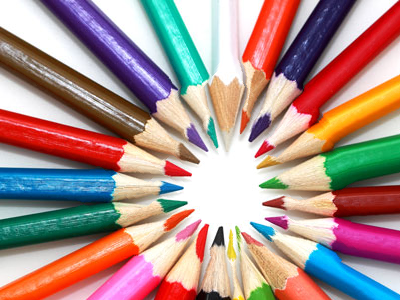

In [14]:
# %%python
"""
PICD-guided Multi-Operator Retargeting with SAM2 Importance and Numba-accelerated Seam Carving
-----------------------------------------------------------------------------------------------
This module wires together:
- A DINOv2 + linear head composition classifier (24 PICD classes)
- SAM2 automatic mask generator (object masks)
- Class-family-aware anchor maps (center, rule-of-thirds, vertical/horizontal lines, diagonals, curves, triangles, perspective)
- A multi-operator retargeting strategy: smart crop / small uniform scale / light seam carving
- Numba-accelerated forward-energy seam carving (vertical & horizontal seams)
Notes:
- You must provide your trained linear head checkpoint path.
- For label mapping: by default we assume the category index order equals the Category IDs you shared (1..24).
  If your dataset uses a different label index order, update INDEX_TO_ABBR accordingly.
- SAM2 requires its repo + weights. This loader expects the "sam2" package import path available.
- Enlargement (seam insertion) is not implemented here; the pipeline prefers crop/scale for upscaling.
Author: YOU + ChatGPT
"""

from __future__ import annotations
import math
import os
import warnings
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

import numpy as np

# Suppress warnings for cleaner notebook output
warnings.filterwarnings('ignore')

# Optional heavy deps are imported lazily to avoid import errors when the module is loaded just for reading.
try:
    import torch
    import torch.nn as nn
    from torchvision import transforms
    from PIL import Image
    from IPython.display import display, Image as IPImage
except Exception:
    print("WARNING: PyTorch, torchvision, or PIL not found. DINOClassifier and image loading will fail.")
    torch = None
    nn = object
    transforms = None
    Image = None
    IPImage = None
    display = print

# numba is recommended. We'll fallback to pure numpy if unavailable.
try:
    from numba import njit
    NUMBA_AVAILABLE = True
except Exception:
    NUMBA_AVAILABLE = False
    print("WARNING: Numba not found. Seam carving will be much slower.")
    def njit(*args, **kwargs):
        def wrap(fn): return fn
        return wrap

# Optional: OpenCV for edges/lines/crop utilities
try:
    import cv2
    OPENCV_AVAILABLE = True
except Exception:
    OPENCV_AVAILABLE = False
    print("WARNING: OpenCV (cv2) not found. Using numpy/scipy fallbacks for some operations (saliency, blur, resize).")

# -------------------------
# PICD label vocabulary and grouping
# -------------------------

# If your dataset indexing differs, edit this list so that index i maps to the correct abbreviation.
INDEX_TO_ABBR: List[str] = [
    "P-RoT",    # 0 -> Category ID 1  (Single Point RoT)
    "S-RoT",    # 1 -> 2
    "P-Cent",   # 2 -> 3
    "S-Cent",   # 3 -> 4
    "P-Dia",    # 4 -> 5
    "LS-Dia",   # 5 -> 6
    "P-Hori",   # 6 -> 7
    "LS-Hori2", # 7 -> 8
    "LS-Hori3", # 8 -> 9
    "S-Hori",   # 9 -> 10
    "P-Ver",    # 10 -> 11
    "L-Ver2",   # 11 -> 12
    "L-Ver3",   # 12 -> 13
    "L-VerMul", # 13 -> 14
    "P-Tri",    # 14 -> 15
    "LS-Tri",   # 15 -> 16
    "LS-C-Cur", # 16 -> 17
    "LS-O-Cur", # 17 -> 18
    "LS-S-Cur", # 18 -> 19
    "LS-Dif",   # 19 -> 20
    "S-Per",    # 20 -> 21
    "PL-Den",   # 21 -> 22
    "PL-Pat",   # 22 -> 23
    "P-Scat",   # 23 -> 24
]

GROUP_NAMES: Dict[int, str] = {
    0: "Centered",
    1: "Rule-of-Thirds",
    2: "Middle-Line",
    3: "Arranged-Multi (H/V)",
    4: "Diagonal",
    5: "Triangle",
    6: "Curves",
    7: "Texture/Pattern/Diffuse/Scatter",
    8: "Perspective",
}

# Group classes by abbreviation. Adjust as you see fit.
ABBR_TO_GROUP: Dict[str, int] = {
    # Centered
    "S-Cent": 0, "P-Cent": 0,
    # RoT
    "S-RoT": 1, "P-RoT": 1, "LS-Hori3": 1, "L-Ver3": 1,
    # Middle-line
    "LS-Hori2": 2, "L-Ver2": 2,
    # Arranged Multi
    "L-VerMul": 3, "S-Hori": 3, "P-Hori": 3, "P-Ver": 3,
    # Diagonal
    "LS-Dia": 4, "P-Dia": 4,
    # Triangle
    "P-Tri": 5, "LS-Tri": 5,
    # Curves
    "LS-C-Cur": 6, "LS-O-Cur": 6, "LS-S-Cur": 6,
    # Texture/Pattern/Diffuse/Scatter
    "PL-Pat": 7, "PL-Den": 7, "LS-Dif": 7, "P-Scat": 7,
    # Perspective
    "S-Per": 8,
}

CATEGORY_TO_GROUP: Dict[int, int] = {i: ABBR_TO_GROUP.get(INDEX_TO_ABBR[i], 7) for i in range(len(INDEX_TO_ABBR))}


# -------------------------
# DINOv2 + Linear Head
# -------------------------

class DINOClassifier(nn.Module):
    def __init__(self, num_classes: int = 24):
        super().__init__()
        assert torch is not None, "PyTorch is required for DINOClassifier"
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        self.dino.eval()
        for p in self.dino.parameters():
            p.requires_grad = False
        # ViT-B/14 output dim for global features in dinov2 is 768
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, x):
        with torch.no_grad():
            feats = self.dino(x)
        return self.classifier(feats)


def build_composition_model(
    ckpt_path: str,
    device: Optional[torch.device] = None,
) -> DINOClassifier:
    assert torch is not None and nn is not object, "PyTorch is required"
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DINOClassifier(num_classes=24).to(device)
    if not Path(ckpt_path).exists():
        print(f"[WARN] Checkpoint not found at {ckpt_path}. The linear head will be randomly initialized.")
    else:
        ckpt = torch.load(ckpt_path, map_location=device)
        # Support both formats
        if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
            model.classifier.load_state_dict(ckpt["model_state_dict"])
        else:
            model.load_state_dict(ckpt)
    model.eval()
    return model


@torch.inference_mode()
def detect_composition(image_rgb: np.ndarray, model: DINOClassifier, device: torch.device):
    """
    Returns: (group_id, group_name, category_idx, probs)
    """
    global transforms, Image
    assert transforms is not None and Image is not None, "torchvision + PIL are required"
    t = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = t(Image.fromarray(image_rgb)).unsqueeze(0).to(device)
    logits = model(img_tensor)
    probs = torch.softmax(logits, dim=1).squeeze(0)
    category = int(logits.argmax(dim=1).item())
    group_id = CATEGORY_TO_GROUP[category]
    return group_id, GROUP_NAMES[group_id], category, probs.detach().cpu().numpy()


# -------------------------
# SAM2 wrapper
# -------------------------

class SAM2ImportanceMap:
    """
    Thin wrapper around SAM2 automatic mask generator to produce an object-importance raster.
    Scoring combines saliency + (optional) center bias + mask area.
    """
    def __init__(self,
                 device: Optional["torch.device"] = None,
                 points_per_side: int = 24,
                 points_per_batch: int = 64,
                 pred_iou_thresh: float = 0.7,
                 stability_score_thresh: float = 0.92):
        assert torch is not None, "PyTorch is required for SAM2 wrapper"
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        from sam2.build_sam import build_sam2
        from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

        checkpoint = "sam2_hiera_large.pt"
        config = "sam2_hiera_l.yaml"
        if not Path(checkpoint).exists():
            raise FileNotFoundError(
                f"Missing {checkpoint}. Download from the official URL and place it next to this script."
            )
        self.sam2 = build_sam2(config_file=config, ckpt_path=checkpoint, device=self.device)
        self.mask_generator = SAM2AutomaticMaskGenerator(
            model=self.sam2,
            points_per_side=points_per_side,
            points_per_batch=points_per_batch,
            pred_iou_thresh=pred_iou_thresh,
            stability_score_thresh=stability_score_thresh
        )

    def _saliency(self, image_rgb: np.ndarray) -> np.ndarray:
        H, W = image_rgb.shape[:2]
        if OPENCV_AVAILABLE:
            try:
                sal = cv2.saliency.StaticSaliencySpectralResidual_create()
                ok, sal_map = sal.computeSaliency(image_rgb)
                if ok:
                    sal_map = (sal_map * 1.0).astype(np.float32)
                    return sal_map
            except Exception:
                pass
        # Fallback: gradient magnitude as a proxy
        gray = to_gray(image_rgb)
        gx = np.abs(np.gradient(gray, axis=1))
        gy = np.abs(np.gradient(gray, axis=0))
        mag = (gx + gy).astype(np.float32)
        mag = mag / (mag.max() + 1e-6)
        return mag

    def generate_importance(self, image_rgb: np.ndarray, top_k: int = 5) -> Tuple[np.ndarray, List[dict]]:
        """
        Returns:
            importance: float32 [H,W] in [0,1]
            masks: list of raw SAM dicts
        """
        H, W = image_rgb.shape[:2]
        masks = self.mask_generator.generate(image_rgb)  # list of dicts
        if len(masks) == 0:
            return np.zeros((H, W), dtype=np.float32), []

        sal = self._saliency(image_rgb)
        # center bias
        center_bias = gaussian2d((H, W), (H/2, W/2), sigma=0.22 * min(H, W))

        scored = []
        for m in masks:
            seg = m["segmentation"].astype(np.uint8)
            if seg.sum() == 0:
                continue
            score = (
                0.6 * (sal[seg > 0].mean()) +
                0.3 * (center_bias[seg > 0].mean()) +
                0.1 * (seg.sum() / float(H * W))
            )
            scored.append((score, seg))
        if not scored:
            return sal.astype(np.float32), []  # fallback to saliency

        scored.sort(key=lambda x: x[0], reverse=True)
        top = scored[:max(1, top_k)]
        imp = np.zeros((H, W), dtype=np.float32)
        for _, seg in top:
            imp = np.maximum(imp, seg.astype(np.float32))
        imp = blur_norm01(imp, k=7)
        return imp, masks


# -------------------------
# Anchor Maps by Class Family
# -------------------------

def gaussian2d(shape_hw: Tuple[int, int], center_hw: Tuple[float, float], sigma: float) -> np.ndarray:
    H, W = shape_hw
    cy, cx = center_hw
    y = np.arange(H, dtype=np.float32)[:, None]
    x = np.arange(W, dtype=np.float32)[None, :]
    g = np.exp(-((y - cy) ** 2 + (x - cx) ** 2) / (2.0 * (sigma ** 2) + 1e-6))
    g = g.astype(np.float32)
    g /= (g.max() + 1e-8)
    return g

def line_field(shape_hw: Tuple[int, int], orientation: str, pos: str, bandwidth: float = 6.0) -> np.ndarray:
    """Builds vertical/horizontal line fields for 'middle' or 'thirds'."""
    H, W = shape_hw
    y = np.arange(H, dtype=np.float32)[:, None]
    x = np.arange(W, dtype=np.float32)[None, :]
    field = np.zeros((H, W), dtype=np.float32)

    if orientation == "vertical":
        if pos == "middle":
            d = np.abs(x - (W - 1) / 2.0)
            field = np.exp(-(d ** 2) / (2 * (bandwidth ** 2)))
        elif pos == "thirds":
            d1 = np.abs(x - (W / 3.0))
            d2 = np.abs(x - (2 * W / 3.0))
            field = np.maximum(
                np.exp(-(d1 ** 2) / (2 * (bandwidth ** 2))),
                np.exp(-(d2 ** 2) / (2 * (bandwidth ** 2))),
            )
    elif orientation == "horizontal":
        if pos == "middle":
            d = np.abs(y - (H - 1) / 2.0)
            field = np.exp(-(d ** 2) / (2 * (bandwidth ** 2)))
        elif pos == "thirds":
            d1 = np.abs(y - (H / 3.0))
            d2 = np.abs(y - (2 * H / 3.0))
            field = np.maximum(
                np.exp(-(d1 ** 2) / (2 * (bandwidth ** 2))),
                np.exp(-(d2 ** 2) / (2 * (bandwidth ** 2))),
            )
    field = field.astype(np.float32)
    field /= (field.max() + 1e-8)
    return field

def power_points(shape_hw: Tuple[int, int], pick: Optional[Tuple[int,int]] = None, sigma: float = 20.0) -> np.ndarray:
    """Gaussian peaks at RoT power points. If 'pick' is provided, emphasize that one."""
    H, W = shape_hw
    points = [
        (H/3.0, W/3.0), (H/3.0, 2*W/3.0),
        (2*H/3.0, W/3.0), (2*H/3.0, 2*W/3.0)
    ]
    acc = np.zeros((H, W), dtype=np.float32)
    for i, (py, px) in enumerate(points):
        g = gaussian2d((H, W), (py, px), sigma=sigma)
        if pick is not None and i == (pick[0] * 2 + pick[1]):
            acc = np.maximum(acc, g)
        else:
            acc = np.maximum(acc, 0.6 * g)  # smaller weight for unpicked
    acc /= (acc.max() + 1e-8)
    return acc

def diagonal_fields(shape_hw: Tuple[int, int], bandwidth: float = 6.0) -> np.ndarray:
    """Protect two main diagonals."""
    H, W = shape_hw
    y = np.arange(H, dtype=np.float32)[:, None]
    x = np.arange(W, dtype=np.float32)[None, :]
    d1 = np.abs((y - 0) - (x - 0))  # main diag
    d2 = np.abs((y - 0) - ((W - 1 - x)))  # anti-diag
    f = np.maximum(
        np.exp(-(d1 ** 2) / (2 * (bandwidth ** 2))),
        np.exp(-(d2 ** 2) / (2 * (bandwidth ** 2)))
    ).astype(np.float32)
    f /= (f.max() + 1e-8)
    return f

def curve_field_from_edges(image_rgb: np.ndarray, ksize: int = 5) -> np.ndarray:
    """Approximate curve protection using edges + smoothing."""
    gray = to_gray(image_rgb)
    if OPENCV_AVAILABLE:
        edges = cv2.Canny((gray * 255).astype(np.uint8), 80, 160)
        edges = edges.astype(np.float32) / 255.0
        edges = cv2.GaussianBlur(edges, (ksize, ksize), 0)
    else:
        gx = np.abs(np.gradient(gray, axis=1))
        gy = np.abs(np.gradient(gray, axis=0))
        edges = gx + gy
        edges = blur_norm01(edges, k=ksize)
    edges /= (edges.max() + 1e-8)
    return edges

def triangle_field_from_masks(image_rgb: np.ndarray, sam_imp: np.ndarray, kpts: int = 3) -> np.ndarray:
    """Try to derive 3 salient points; connect as triangle field."""
    H, W = image_rgb.shape[:2]
    # find peaks in importance map
    imp = (sam_imp / (sam_imp.max() + 1e-6)).copy()
    ys, xs = np.where(imp > 0.5)
    if len(xs) < kpts:
        # Fallback: use corners and center
        pts = [(H/4, W/2), (3*H/4, W/4), (3*H/4, 3*W/4)]
    else:
        # K-means 3 centers in importance coordinates
        coords = np.stack([ys.astype(np.float32), xs.astype(np.float32)], axis=1)
        if len(coords) < kpts:
            pts = [(H/4, W/2), (3*H/4, W/4), (3*H/4, 3*W/4)]
        else:
            pts = kmeans_points(coords, kpts)
    field = np.zeros((H, W), dtype=np.float32)
    for i in range(3):
        for j in range(i+1, 3):
            field = np.maximum(field, line_thickness_map((H, W), pts[i], pts[j], thickness=5.0))
    field /= (field.max() + 1e-8)
    return field

def line_thickness_map(shape_hw: Tuple[int, int], p0: Tuple[float, float], p1: Tuple[float, float], thickness: float) -> np.ndarray:
    H, W = shape_hw
    y = np.arange(H, dtype=np.float32)[:, None]
    x = np.arange(W, dtype=np.float32)[None, :]
    y0, x0 = p0
    y1, x1 = p1
    # Distance from each pixel to the line segment p0-p1
    vx, vy = (x1 - x0), (y1 - y0)
    seg_len2 = max(vx*vx + vy*vy, 1e-6)
    t = ((x - x0) * vx + (y - y0) * vy) / seg_len2
    t = np.clip(t, 0.0, 1.0)
    projx = x0 + t * vx
    projy = y0 + t * vy
    dist = np.sqrt((x - projx)**2 + (y - projy)**2)
    m = np.exp(-(dist**2) / (2 * (thickness**2)))
    m = m.astype(np.float32)
    return m

def kmeans_points(coords: np.ndarray, k: int = 3, iters: int = 20) -> List[Tuple[float, float]]:
    # Tiny KMeans on coords[:,(y,x)]
    N = coords.shape[0]
    idx = np.random.choice(N, k, replace=False)
    centers = coords[idx].copy()
    for _ in range(iters):
        dists = np.sqrt(((coords[:, None, :] - centers[None, :, :]) ** 2).sum(-1))  # [N,k]
        labels = dists.argmin(axis=1)
        new_centers = []
        for i in range(k):
            sel = coords[labels == i]
            if len(sel) == 0:
                new_centers.append(centers[i])
            else:
                new_centers.append(sel.mean(axis=0))
        new_centers = np.stack(new_centers, axis=0)
        if np.allclose(new_centers, centers):
            break
        centers = new_centers
    return [(float(c[0]), float(c[1])) for c in centers]

def to_gray(image_rgb: np.ndarray) -> np.ndarray:
    if image_rgb.ndim == 2:
        gray = image_rgb.astype(np.float32)
        if gray.max() > 1.0: gray = gray / 255.0
        return gray
    img = image_rgb.astype(np.float32)
    if img.max() > 1.0: img = img / 255.0
    gray = 0.299 * img[..., 0] + 0.587 * img[..., 1] + 0.114 * img[..., 2]
    return gray.astype(np.float32)

def blur_norm01(arr: np.ndarray, k: int = 7) -> np.ndarray:
    if OPENCV_AVAILABLE:
        arr = cv2.GaussianBlur(arr.astype(np.float32), (k, k), 0)
    else:
        # naive box blur
        try:
            from scipy.ndimage import gaussian_filter as gf  # if available
            arr = gf(arr.astype(np.float32), sigma=max(1, (k-1)/4))
        except Exception:
            print("SciPy not found, skipping blur.")
            pass
    arr = arr.astype(np.float32)
    m = arr.max()
    if m > 0:
        arr /= m
    return arr

def build_anchor_map(group_id: int,
                       image_rgb: np.ndarray,
                       sam_imp: Optional[np.ndarray] = None,
                       pick_rot_point: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """
    Returns a [H,W] float32 in [0,1] with high values where composition must be preserved.
    """
    H, W = image_rgb.shape[:2]
    anchors = np.zeros((H, W), dtype=np.float32)

    if group_id == 0:  # Centered
        anchors = gaussian2d((H, W), (H/2, W/2), sigma=0.25 * min(H, W))

    elif group_id == 1:  # Rule-of-Thirds family
        anchors = np.maximum(
            line_field((H, W), 'vertical', 'thirds', bandwidth=8.0),
            line_field((H, W), 'horizontal', 'thirds', bandwidth=8.0)
        )
        anchors = np.maximum(anchors, power_points((H, W), pick=pick_rot_point, sigma=0.1*min(H, W)))

    elif group_id == 2:  # Middle line family
        anchors = np.maximum(
            line_field((H, W), 'vertical', 'middle', bandwidth=8.0),
            line_field((H, W), 'horizontal', 'middle', bandwidth=8.0)
        )

    elif group_id == 3:  # Arranged-Multi (H/V)
        hv = np.maximum(
            line_field((H, W), 'vertical', 'thirds', bandwidth=7.0),
            line_field((H, W), 'horizontal', 'thirds', bandwidth=7.0)
        )
        anchors = np.maximum(hv, gaussian2d((H, W), (H/2, W/2), sigma=0.35 * min(H, W)))

    elif group_id == 4:  # Diagonals
        anchors = diagonal_fields((H, W), bandwidth=8.0)

    elif group_id == 5:  # Triangle
        if sam_imp is None:
            anchors = diagonal_fields((H, W), bandwidth=8.0) * 0.4 + gaussian2d((H, W), (H/2, W/2), sigma=0.25*min(H, W))*0.6
        else:
            anchors = triangle_field_from_masks(image_rgb, sam_imp, kpts=3)

    elif group_id == 6:  # Curves
        anchors = curve_field_from_edges(image_rgb, ksize=7)

    elif group_id == 7:  # Texture/Pattern/Diffuse/Scatter
        anchors = np.ones((H, W), dtype=np.float32) * 0.35  # mild, rely more on object & edge costs

    elif group_id == 8:  # Perspective
        # Approximate: emphasize center and a mild radiating field from center
        anchors = gaussian2d((H, W), (H/2, W/2), sigma=0.28 * min(H, W))
        # add faint diagonals to mimic converging lines
        anchors = np.maximum(anchors, diagonal_fields((H, W), bandwidth=10.0) * 0.5)

    return blur_norm01(anchors, k=7)


# -------------------------
# Energy and Numba-accelerated seam carving
# -------------------------

def sobel_energy(gray: np.ndarray) -> np.ndarray:
    if OPENCV_AVAILABLE:
        gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
        e = np.abs(gx) + np.abs(gy)
    else:
        gx = np.abs(np.gradient(gray, axis=1))
        gy = np.abs(np.gradient(gray, axis=0))
        e = gx + gy
    e = e.astype(np.float32)
    return e

@njit(cache=True)
def _accumulate_forward_energy(e: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Rubinstein et al. forward energy for vertical seams.
    e: [H,W] base energy
    Returns:
        M: accumulated cost [H,W]
        backtrack: indices [-1,0,1] direction for each pixel
    """
    H, W = e.shape
    M = np.zeros((H, W), dtype=np.float32)
    back = np.zeros((H, W), dtype=np.int8)

    # First row
    for j in range(W):
        M[0, j] = e[0, j]

    for i in range(1, H):
        for j in range(W):
            # compute costs of coming from left/vertical/right
            if j == 0:
                cU = abs(e[i, j+1] - e[i, j]) if W > 1 else 0.0
                cR = cU + (abs(e[i-1, j] - e[i, j+1]) if W > 1 else 0.0)
                cL = 1e9
            elif j == W - 1:
                cU = abs(e[i, j] - e[i, j-1])
                cL = cU + abs(e[i-1, j] - e[i, j-1])
                cR = 1e9
            else:
                cU = abs(e[i, j+1] - e[i, j-1])
                cL = cU + abs(e[i-1, j] - e[i, j-1])
                cR = cU + abs(e[i-1, j] - e[i, j+1])

            # pick best predecessor
            mU = M[i-1, j] + cU
            mL = M[i-1, j-1] + cL if j > 0 else 1e12
            mR = M[i-1, j+1] + cR if j < W-1 else 1e12

            if mL <= mU and mL <= mR:
                M[i, j] = e[i, j] + mL
                back[i, j] = -1
            elif mR <= mU and mR <= mL:
                M[i, j] = e[i, j] + mR
                back[i, j] = 1
            else:
                M[i, j] = e[i, j] + mU
                back[i, j] = 0
    return M, back

@njit(cache=True)
def _trace_seam(back: np.ndarray, M: np.ndarray) -> np.ndarray:
    H, W = back.shape
    seam = np.zeros(H, dtype=np.int32)
    # start at min of last row
    j = 0
    minval = 1e20
    for jj in range(W):
        if M[H-1, jj] < minval:
            minval = M[H-1, jj]
            j = jj
    seam[H-1] = j
    for i in range(H-2, -1, -1):
        move = back[i+1, j]
        j = j + int(move)
        j = min(max(j, 0), W-1)
        seam[i] = j
    return seam

def remove_vertical_seam(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    H, W = img.shape[:2]
    mask = np.ones((H, W), dtype=np.bool_)
    mask[np.arange(H), seam] = False
    if img.ndim == 3:
        carved = img[mask].reshape(H, W-1, img.shape[2])
    else:
        carved = img[mask].reshape(H, W-1)
    return carved

def insert_vertical_seam(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    # Not used in this pipeline (we avoid seam insertion).
    H, W = img.shape[:2]
    out = np.zeros((H, W+1, img.shape[2]), dtype=img.dtype) if img.ndim == 3 else np.zeros((H, W+1), dtype=img.dtype)
    for i in range(H):
        j = seam[i]
        if img.ndim == 3:
            out[i, :j+1] = img[i, :j+1]
            out[i, j+1] = img[i, j]
            out[i, j+2:] = img[i, j+1:]
        else:
            out[i, :j+1] = img[i, :j+1]
            out[i, j+1] = img[i, j]
            out[i, j+2:] = img[i, j+1:]
    return out

def vertical_seam_cost(gray: np.ndarray, importance: Dict[str, np.ndarray], lambdas: Dict[str, float]) -> np.ndarray:
    base = sobel_energy(gray)
    # Forward energy DP uses 'base' as e; inject penalties by increasing base
    penalty = (
        lambdas.get("lambda_struct", 0.0) * importance.get("structure", np.zeros_like(base)) +
        lambdas.get("lambda_anchor", 0.0) * importance.get("anchors", np.zeros_like(base)) +
        lambdas.get("lambda_obj", 0.0) * importance.get("objects", np.zeros_like(base))
    )
    if isinstance(penalty, dict):
        raise ValueError("importance is expected to be dict[str->np.ndarray], not dict of dict")
    pen = penalty.astype(np.float32)
    if pen.max() > 0:
        pen = pen / pen.max()
    e = base + lambdas.get("lambda_fwd", 1.0) * base + lambdas.get("lambda_pen", 1.0) * pen
    e = e.astype(np.float32)
    return e

def carve_vertical(img: np.ndarray,
                   importance_maps: Dict[str, np.ndarray],
                   n: int,
                   lambdas: Dict[str, float],
                   update_maps: bool = True) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    carved_img = img.copy()
    imp = {k: v.copy() for k, v in importance_maps.items()}
    for _ in range(n):
        gray = to_gray(carved_img)
        e = vertical_seam_cost(gray, imp, lambdas)
        M, back = _accumulate_forward_energy(e)
        seam = _trace_seam(back, M)
        # remove seam from image and importance maps
        carved_img = remove_vertical_seam(carved_img, seam)
        if update_maps:
            for k in imp:
                imp[k] = remove_vertical_seam(imp[k], seam)
    return carved_img, imp

def carve_horizontal(img: np.ndarray,
                     importance_maps: Dict[str, np.ndarray],
                     n: int,
                     lambdas: Dict[str, float],
                     update_maps: bool = True) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    # Transpose trick
    img_t = np.transpose(img, (1, 0, 2)) if img.ndim == 3 else img.T
    imps_t = {k: v.T for k, v in importance_maps.items()}
    carved_t, imps_t = carve_vertical(img_t, imps_t, n, lambdas, update_maps)
    carved = np.transpose(carved_t, (1, 0, 2)) if img.ndim == 3 else carved_t.T
    imps = {k: v.T for k, v in imps_t.items()}
    return carved, imps


# -------------------------
# Smart crop utilities
# -------------------------

def integral_image(arr: np.ndarray) -> np.ndarray:
    s = arr.cumsum(axis=0).cumsum(axis=1)
    return s

def window_sum(ii: np.ndarray, y0: int, x0: int, y1: int, x1: int) -> float:
    # inclusive-exclusive on integral image
    res = ii[y1, x1]
    if y0 > 0: res -= ii[y0 - 1, x1]
    if x0 > 0: res -= ii[y1, x0 - 1]
    if y0 > 0 and x0 > 0: res += ii[y0 - 1, x0 - 1]
    return float(res)

def best_crop_window(imp: np.ndarray, target_h: int, target_w: int) -> Tuple[int, int, int, int]:
    """
    Find crop window that MAXIMIZES retained importance.
    Returns (y0, x0, y1, x1) inclusive indices.
    """
    H, W = imp.shape[:2]
    target_h = min(target_h, H)
    target_w = min(target_w, W)
    ii = integral_image(imp.astype(np.float64))
    best = (-1e18, 0, 0)
    best_rc = (0, 0, target_h - 1, target_w - 1)
    for y0 in range(0, H - target_h + 1):
        y1 = y0 + target_h - 1
        for x0 in range(0, W - target_w + 1):
            x1 = x0 + target_w - 1
            s = window_sum(ii, y0, x0, y1, x1)
            if s > best[0]:
                best = (s, y0, x0)
                best_rc = (y0, x0, y1, x1)
    return best_rc

def crop_to_window(img: np.ndarray, rc: Tuple[int, int, int, int]) -> np.ndarray:
    y0, x0, y1, x1 = rc
    return img[y0:y1+1, x0:x1+1].copy()


# -------------------------
# Multi-operator pipeline
# -------------------------

@dataclass
class RetargetParams:
    max_sc_ratio: float = 0.12  # maximum fraction per dimension for seam carving
    # penalties
    lambda_fwd: float = 0.8
    lambda_pen: float = 6.0
    lambda_struct: float = 1.0
    lambda_anchor: float = 2.0
    lambda_obj: float = 3.0
    # SAM
    sam_topk: int = 5


def build_importance_bundle(image_rgb: np.ndarray,
                            group_id: int,
                            sam_model: Optional[SAM2ImportanceMap]) -> Dict[str, np.ndarray]:
    H, W = image_rgb.shape[:2]
    # Objects (SAM)
    if sam_model is not None:
        sam_imp, _ = sam_model.generate_importance(image_rgb, top_k=5)
    else:
        sam_imp = np.zeros((H, W), dtype=np.float32)
    # Structure (edges)
    struct_imp = curve_field_from_edges(image_rgb, ksize=5)
    # Anchors
    anchors = build_anchor_map(group_id, image_rgb, sam_imp=sam_imp)
    # Normalize each
    for arr in (sam_imp, struct_imp, anchors):
        m = arr.max()
        if m > 0:
            arr /= m
    return {"objects": sam_imp, "structure": struct_imp, "anchors": anchors}


def plan_crop_then_sc(H: int, W: int, target_h: int, target_w: int, max_sc_ratio: float) -> Tuple[int, int, int, int]:
    """
    Decide intermediate crop size so that remaining delta can be handled by SC within max_sc_ratio.
    Returns: (crop_h, crop_w, sc_rows, sc_cols)
    """
    crop_h, crop_w = H, W
    rem_h = H - target_h
    rem_w = W - target_w

    # vertical (width) plan
    if rem_w > 0:
        # how many cols can SC remove safely?
        sc_max_w = int(math.floor(max_sc_ratio * W))
        if rem_w > sc_max_w:
            crop_w = W - (rem_w - sc_max_w)

    # horizontal (height) plan
    if rem_h > 0:
        sc_max_h = int(math.floor(max_sc_ratio * H))
        if rem_h > sc_max_h:
            crop_h = H - (rem_h - sc_max_h)

    # residual for SC after crop
    sc_cols = max(0, crop_w - target_w)
    sc_rows = max(0, crop_h - target_h)
    return crop_h, crop_w, sc_rows, sc_cols


def retarget_image(
    image_rgb: np.ndarray,
    target_w: int,
    target_h: int,
    composition_model: Optional[DINOClassifier] = None,
    sam_model: Optional[SAM2ImportanceMap] = None,
    device: Optional["torch.device"] = None,
    params: Optional[RetargetParams] = None,
    debug: bool = False,
) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """
    Multi-operator pipeline: smart crop -> (optional small scale) -> seam carving residual.
    Returns: (retargeted_image_rgb, debug_maps)
    """
    params = params or RetargetParams()
    device = device or (torch.device('cuda' if torch and torch.cuda.is_available() else 'cpu') if torch else None)

    H, W = image_rgb.shape[:2]

    # 1) composition detection
    if composition_model is not None and torch is not None:
        gid, gname, cat, probs = detect_composition(image_rgb, composition_model, device)
    else:
        gid, gname, cat, probs = 7, GROUP_NAMES[7], -1, None  # fallback

    # 2) importance maps
    imp_bundle = build_importance_bundle(image_rgb, gid, sam_model)
    imp_total = np.maximum.reduce(list(imp_bundle.values()))
    imp_total = blur_norm01(imp_total, k=7)

    dbg = {}
    if debug:
        dbg["importance_total"] = imp_total
        for k, v in imp_bundle.items():
            dbg[f"imp_{k}"] = v
        dbg["group_id"] = gid
        dbg["group_name"] = gname
        dbg["category_idx"] = cat
        dbg["probs"] = probs

    # 3) plan crop vs seam carving amounts
    crop_h, crop_w, sc_rows, sc_cols = plan_crop_then_sc(H, W, target_h, target_w, params.max_sc_ratio)

    # 4) smart crop to (crop_h, crop_w)
    cur = image_rgb.copy()
    if (crop_h, crop_w) != (H, W):
        # choose crop window to maximize retained importance
        rc = best_crop_window(imp_total, crop_h, crop_w)
        cur = crop_to_window(cur, rc)
        # crop importance too
        for k in imp_bundle:
            imp_bundle[k] = crop_to_window(imp_bundle[k], rc)
    
    # 5) optional small uniform scale to reach closer to target
    # (Here we skip intermediate scaling for simplicity; you can add if desired.)

    # 6) seam carve residual
    lambdas = {
        "lambda_fwd": params.lambda_fwd,
        "lambda_pen": params.lambda_pen,
        "lambda_struct": params.lambda_struct,
        "lambda_anchor": params.lambda_anchor,
        "lambda_obj": params.lambda_obj,
    }
    if sc_cols > 0:
        cur, imp_bundle = carve_vertical(cur, imp_bundle, sc_cols, lambdas, update_maps=True)
    if sc_rows > 0:
        cur, imp_bundle = carve_horizontal(cur, imp_bundle, sc_rows, lambdas, update_maps=True)

    # 7) final resize to exact target if 1–2 px off (numerics)
    final = cur
    fh, fw = final.shape[:2]
    if (fw != target_w) or (fh != target_h):
        if OPENCV_AVAILABLE:
            final = cv2.resize(final, (target_w, target_h), interpolation=cv2.INTER_AREA)
        else:
            from PIL import Image as PILImage
            final = np.array(PILImage.fromarray(final).resize((target_w, target_h), resample=PILImage.BILINEAR))

    return final, dbg


# -------------------------
# Convenience: I/O helpers
# -------------------------

def _load_image(path: str) -> np.ndarray:
    from PIL import Image as PILImage
    img = np.array(PILImage.open(path).convert("RGB"))
    return img

def _save_image(path: str, img: np.ndarray) -> None:
    from PIL import Image as PILImage
    PILImage.fromarray(img).save(path)

# ==============================================================================
# 🚀 JUPYTER NOTEBOOK EXECUTION CELL
# ==============================================================================
#
# This block replaces the original `if __name__ == "__main__":` and `example_cli`
#
# ------------------------------------------------------------------------------
# ⚙️ CONFIGURATION: Tweak these parameters to run the demo
# ------------------------------------------------------------------------------

# 1. User-provided input image path
input_path = "PruneRepaint/input/retargetme/pencils.png"

# 2. Desired output size
target_width = 400
target_height = 300

# 3. Path to your trained DINO classifier checkpoint
#    (Set to "DUMMY_PATH.pth" if you don't have one and want to skip)
classifier_ckpt_path = "/scratch.global/kanth042/CV_project/best_dino_classifier.pth"

# 4. Output paths
output_path = "retargeted_output.png"
run_debug_mode = True  # Set to True to save all intermediate maps

# ------------------------------------------------------------------------------
# ⚡️ EXECUTION LOGIC
# ------------------------------------------------------------------------------

print(f"--- Starting Retargeting Process ---")
print(f"Input: {input_path}")
print(f"Target Size: {target_width}x{target_height}")

# Load image
try:
    img = _load_image(input_path)
    print(f"Loaded image, shape: {img.shape}")
except Exception as e:
    print(f"!! FAILED to load image at {input_path}: {e}")
    # Stop execution if image fails to load
    raise e

# Build classifier (optional)
comp_model = None
device = None
if torch is not None:
    print("Trying to build composition model...")
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        comp_model = build_composition_model(classifier_ckpt_path, device=device)
        print("Composition model built.")
    except Exception as e:
        print(f"[WARN] Could not build composition model: {e}")
else:
    print("[WARN] PyTorch not found. Skipping composition model.")


# Build SAM2 (optional)
sam_model = None
print("Trying to build SAM2 model...")
try:
    sam_model = SAM2ImportanceMap(device=device) # Pass device
    print("SAM2 model built.")
except Exception as e:
    print(f"[WARN] SAM2 not available: {e}. Proceeding without SAM importance.")

# Run the full pipeline
print("Running retarget_image pipeline...")
final, dbg = retarget_image(
    img, target_width, target_height,
    composition_model=comp_model,
    sam_model=sam_model,
    device=device,
    params=RetargetParams(), # Use default params
    debug=run_debug_mode
)
print("Pipeline finished.")

# Save main output
_save_image(output_path, final)
print(f"[OK] Wrote main output to {output_path}")

# Save debug maps if enabled
if run_debug_mode:
    print("Saving debug maps...")
    output_dir = Path(output_path).parent
    output_stem = Path(output_path).stem
    
    for k, v in dbg.items():
        if k.startswith("imp_") or k == "importance_total":
            vis = (np.clip(v, 0, 1) * 255).astype(np.uint8)
            debug_out_path = output_dir / f"{output_stem}_{k}.png"
            _save_image(str(debug_out_path), vis)
    print(f"Debug maps saved with prefix '{output_stem}_'")
    print(f"Composition Group: {dbg.get('group_name', 'N/A')} (ID: {dbg.get('group_id', 'N/A')})")

print("--- Process Complete ---")

# ------------------------------------------------------------------------------
# 🖼 DISPLAY RESULT IN NOTEBOOK
# ------------------------------------------------------------------------------
print(f"\nDisplaying final result ({output_path}):")
if IPImage:
    try:
        display(IPImage(filename=output_path))
    except Exception as e:
        print(f"Could not display image in notebook: {e}")
else:
    print("IPython not available to display image.")